<a href="https://colab.research.google.com/github/john-reilly/RoboFarm/blob/master/Apples_version2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive

drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#if google colab base_dir is one thing else another
base_dir = '/content/gdrive/My Drive/'

In [0]:
#REQUIREMENTS 
!Flask==0.11.1
!attrdict==2.0.0
!eventlet==0.19.0
!numpy==1.13.1
!scipy==0.19.1
!keras==2.0.8
!tensorflow==1.3.0
!h5py==2.6.0
!pandas==0.24.2
!Pillow==2.8.0

In [0]:
import os
import random
import time

import tensorflow as tf
import numpy as np
from PIL import Image, ImageOps


class ObjectDetector:

    def __init__(self,location_path = base_dir, graph_filename = 'frozen_inference_graph.pb' ):       
        self.detection_graph = tf.Graph()
        with self.detection_graph.as_default():
            od_graph_def = tf.GraphDef()
            try:
                with tf.gfile.GFile( location_path + graph_filename, 'rb') as fid:
                    serialized_graph = fid.read()
                    od_graph_def.ParseFromString(serialized_graph)
                    tf.import_graph_def(od_graph_def, name='')
                    self.session = tf.Session(graph=self.detection_graph)
            except Exception as e:
                print(e)
                exit()


    def run_inference_for_single_image(self, image, show_stats = True ):
        # Get handles to input and output tensors
        ops = self.detection_graph.get_operations()
        all_tensor_names = {output.name for op in ops for output in op.outputs}
        tensor_dict = {}
        for key in ['num_detections', 'detection_boxes', 'detection_scores', 'detection_classes']:
            tensor_name = key + ':0'
            if tensor_name in all_tensor_names:
                tensor_dict[key] = self.detection_graph.get_tensor_by_name(tensor_name)
        image_tensor = self.detection_graph.get_tensor_by_name('image_tensor:0') #indentation?

        # Run inference
        start = time.time()
        output_dict = self.session.run(tensor_dict, feed_dict={image_tensor: np.expand_dims(image, 0)})
        elapsed = time.time() - start
        #print('inference took:', elapsed, ' seconds') 
        
        # all outputs are float32 numpy arrays, so convert types as appropriate
        output_dict['num_detections'] = int(output_dict['num_detections'][0])
        output_dict['detection_classes'] = output_dict['detection_classes'][0].astype(np.uint8)
        output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
        output_dict['detection_scores'] = output_dict['detection_scores'][0]

        if show_stats == True:
          print('inference took:', elapsed, ' seconds') 
          print("num_detections:" , output_dict['num_detections'])
          print("Detection Classes: " , output_dict['detection_classes'])
          print("Detection Scores: " , output_dict['detection_scores'])

        return output_dict

    def overlay_bounding_boxes(self, image, output_dict,detection_class, probability_level, draw_boxes = False):
        classes = output_dict['detection_classes']
        boxes = output_dict['detection_boxes']
        scores = output_dict['detection_scores']

        height, width, _ = image.shape

        tf_boxes = []
        output_images = []
        for i in range(len(boxes)):
            confidence = float(scores[i])
            ymin, xmin, ymax, xmax = tuple(boxes[i].tolist())
            ymin = int(ymin * height)
            ymax = int(ymax * height)
            xmin = int(xmin * width)
            xmax = int(xmax * width)
            box_width = xmax - xmin
            box_height = ymax - ymin
            box_ratio = float(box_height) / box_width 
            #filter criteria
            if confidence >= probability_level and \
              classes[i] == detection_class :
                # also possible and \  #box_ratio >= 0.75     #box_width > 21   #box_height > 20
                #draw rectanlge around object having this here interferes with later on as cropped images have rectanlge over writes
                if draw_boxes:
                  cv2.rectangle(image, (xmin,ymin) , (xmax, ymax) , (255,0,0) ,2)
                #record object data
                tf_boxes.append(boxes[i])
                #crop object out of image for further processing
                crop_image = image[ymin:ymax, xmin:xmax]
                crop_output_image = Image.fromarray(crop_image)
                output_images.append(crop_output_image)
                
        return image, tf_boxes , output_images# <------your version might not need to return all 3



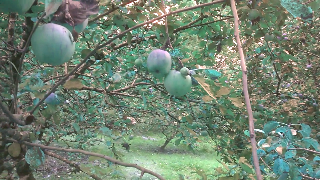

inference took: 5.016517400741577  seconds
num_detections: 100
Detection Classes:  [53 53 53 53 53 53 53 53 53 53 53 53 53 53 55 53 53 56 53 16 53 37 53 53
 37 53 53 56 53 56 53 56 53 56 56 56 53 56 53 53 53 56 53 56 56 56 56 56
 56 53 56 56 56 56 53 56 56 53 56 53 56 56 56 56 53 56 53 56 56 56 56 56
 56 56 56 53 56 56 56 56 53 56 56 56 53 53 53 56 53 56 53 56 56 56 56 53
 56 56 56 56]
Detection Scores:  [0.9486543  0.36964118 0.23162872 0.22308162 0.19798157 0.19271055
 0.13437158 0.12559202 0.11918971 0.11855003 0.11543727 0.10813445
 0.10616213 0.10538718 0.0977281  0.09762129 0.09584737 0.0925009
 0.09211206 0.08816451 0.08651966 0.08648583 0.08639628 0.08523253
 0.08368209 0.08155513 0.08137435 0.08126152 0.08096552 0.0781801
 0.07725859 0.07651231 0.07630458 0.07622981 0.07616314 0.07542837
 0.07515967 0.07393935 0.07013512 0.06993729 0.069534   0.06897652
 0.06857097 0.06788659 0.06781188 0.0677689  0.06733987 0.06654024
 0.06597689 0.06580704 0.06577411 0.06576103 0.06522867 0.

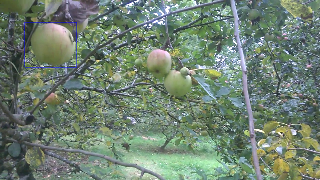

In [0]:

from google.colab.patches import cv2_imshow
from moviepy.editor import VideoFileClip
from IPython.display import HTML #from my lane line project
import cv2

clip1 = VideoFileClip(base_dir + 'APPLE_VIDEO.MP4')
frame = clip1.get_frame(19)#3) #19

#Before processing
#frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
cv2_imshow( cv2.resize(frame, None, fx = 0.25 , fy = 0.25, interpolation = cv2.INTER_CUBIC) )


my_detector = ObjectDetector(base_dir , 'frozen_inference_graph.pb')
output_dict = my_detector.run_inference_for_single_image(frame, show_stats = True)# False) # True)
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)#is rgb getting screwed up?
final_image, object_data, object_images  = my_detector.overlay_bounding_boxes( frame, output_dict,53, 0.80, draw_boxes = True)#False ) #True)
#After processing
#cv2_imshow(final_image)
cv2_imshow( cv2.resize(final_image, None, fx = 0.25 , fy = 0.25, interpolation = cv2.INTER_CUBIC) )


In [0]:
#TRAIN.py
# Load the data

import gzip
import re
import os

import numpy as np
import pandas as pd
from time import time
from PIL import Image, ImageOps

from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import keras.layers as layers
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.callbacks import TensorBoard
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.backend import tensorflow_backend as ktf
from pathlib import Path

from os import listdir
from os.path import isfile, join


apple_type = ['ripe', 'not_ripe']
apple_type_categories = [[1,0], [0,1]]

RESIZED_DIR = base_dir + 'data/' + 'Ripe_not_ripe/' + 'images_resized/'

def read_images(images_path):
    labels = []
    features = []
    for root, dirs, files in os.walk(images_path, topdown=False):
        
        path = os.path.dirname(images_path + 'images_resized/')
        Path(path).mkdir(exist_ok=True)
        
        for filename in files:
            added = False
        
            for index, color in enumerate(apple_type):              
                labels.append(apple_type_categories[index])
                print(images_path + apple_type[index]+ '/' + filename)
                img = load_img(images_path + apple_type[index]+ '/' + filename)
                img = crop_image(img)
                img.save('{}{}{}'.format(RESIZED_DIR,  apple_type[index]+ '/' ,filename), 'JPEG')
                x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150) 
                features.append(x)
                added = True
                break
            if not added:
                print('Error invalid filename:', filename)

    return np.array(features), np.array(labels)

def preprocess_images(images_path):
  
    if not os.path.exists(images_path + 'preprocessed/' + 'ripe/' ):
      os.makedirs(images_path + 'preprocessed/' + 'ripe/' )
  
    for root, dirs, files in os.walk(images_path+'ripe/', topdown=True):    
      for filename in files:
        img = load_img(images_path + 'ripe/' + filename)
        img = crop_image(img)
        img.save(images_path + 'preprocessed/' + 'ripe/' + filename)


    if not os.path.exists(images_path + 'preprocessed/' + 'not_ripe/' ):
      os.mkdir(images_path + 'preprocessed/' + 'not_ripe/' )

    for root, dirs, files in os.walk(images_path+'not_ripe/', topdown=True):    
      for filename in files:
        img = load_img(images_path + 'not_ripe/' + filename)
        img = crop_image(img)
        img.save(images_path + 'preprocessed/' + 'not_ripe/' + filename)


def load_prepared_images(images_path):
  
  features = []
  labels = []

  for root, dirs, files in os.walk(images_path+'ripe/', topdown=True):    
    for filename in files:
      img = load_img(images_path + 'ripe/' + filename)
      x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150) #john 32*32 ?
      features.append(x)
      labels.append(apple_type_categories[0])


  for root, dirs, files in os.walk(images_path+'not_ripe/', topdown=True):    
    for filename in files:
      img = load_img(images_path + 'not_ripe/' + filename)
      x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150) #john 32*32 ?
      features.append(x)
      labels.append(apple_type_categories[1])
     

  return np.array(features), np.array(labels)


def remove_ext(filename):
    return re.sub(r'\.png|\.jpeg|\.jpg', '', filename, re.IGNORECASE)

def crop_image(img):
    img.thumbnail((32, 32), Image.ANTIALIAS)
    width, height = img.size
    delta_w = 32 - width
    delta_h = 32 - height
    padding = (delta_w // 2, delta_h // 2, delta_w - (delta_w // 2), delta_h - (delta_h // 2))
    img = ImageOps.expand(img, padding, fill=0)  # fill with black dots
    return img



features, labels = load_prepared_images(base_dir + 'data/' + 'Ripe_not_ripe/' + 'preprocessed/')

train = {}
test = {}

train['features'], test['features'], train['labels'], test['labels'] = train_test_split(features, labels, test_size=0.05)

# explore the data

print('# of training images:', train['features'].shape[0])
print('# of test images:', test['features'].shape[0])

# plot training data
train_labels_count = np.unique(train['labels'], return_counts=True)
dataframe_train_labels = pd.DataFrame({'Label':train_labels_count[0], 'Count':train_labels_count[1]})
print(dataframe_train_labels)

# Split training data into training and validation
validation = {}
train['features'], validation['features'], train['labels'], validation['labels'] = train_test_split(train['features'], train['labels'], test_size=0.2, random_state=0)

print('# of training images:', train['features'].shape[0])
print('# of validation images:', validation['features'].shape[0])

print(features.shape)
print(labels.shape)

print("Updated Image Shape: {}".format(train['features'][0].shape))

model = Sequential()

model.add(layers.Lambda(lambda x: x/255.0 - 0.5, input_shape=(32,32,3))) # added

model.add(layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(32,32,3)))
model.add(layers.AveragePooling2D())

model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model.add(layers.AveragePooling2D())

model.add(layers.Flatten())

model.add(layers.Dense(units=120, activation='relu'))

model.add(layers.Dense(units=84, activation='relu'))

model.add(layers.Dense(units=2, activation = 'softmax')) #for 2 categories

model.summary()

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
model.fit(train['features'], train['labels'], epochs=52, validation_split=0.3, shuffle=True, callbacks=[tensorboard])


score = model.evaluate(test['features'], test['labels'])
print('Test loss:', score[0])
print('Test accuracy:', score[1])

model.save(base_dir + 'apple_lenet_model.h5')

# of training images: 243
# of test images: 13
   Label  Count
0      0    243
1      1    243
# of training images: 194
# of validation images: 49
(256, 32, 32, 3)
(256, 2)
Updated Image Shape: (32, 32, 3)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 30, 30, 6)         168       
_________________________________________________________________
average_pooling2d_3 (Average (None, 15, 15, 6)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 16)        880       
_________________________________________________________________
average_pooling2d_4 (Average (None, 6, 6, 16)          0         
_____________________________________________

In [0]:
#classify.py

import numpy as np
from keras.models import load_model
from keras.preprocessing.image import img_to_array, load_img
import time
import os

#class_model = load_model(base_dir + 'apple_lenet_model.h5')

#traffic_light_colors = ['ripe', 'not_ripe']

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


class ObjectClassifier:

    def __init__(self,location_path = base_dir, model_name = 'apple_lenet_model.h5' ):       
  
            try:
              self.class_model = load_model(base_dir + 'apple_lenet_model.h5')
              
            except Exception as e:
                print(e)
                exit()

            self.traffic_light_colors = ['ripe', 'not_ripe']

    def predict(self,image_name):

        img = load_img(image_name, False, target_size=(32, 32))
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)
        preds = self.class_model.predict_classes(x)
        prob = selfclass_model.predict_proba(x)

        return preds[0], prob[0]

    def predict_for_detected(self, image_name):
      
        resized_image = image_name.resize((32,32), resample=0)

        x = img_to_array(resized_image)
        x = np.expand_dims(x, axis=0)
        preds = self.class_model.predict_classes(x)
        prob = self.class_model.predict_proba(x)

        return preds[0], prob[0]

    def draw_positive_boxes(self,final_image,object_data, object_images, show_each_addition =  False ):

      height, width ,_ = final_image.shape #  as per PIL
      print('final_image.shape : ', final_image.shape)


      for   i in  range(0, len(object_images ) ) :
        start = time.time()
        pred, prob = self.predict_for_detected( object_images[i]) #originally self was not here then it gave trouble for no reason

        #plt.imshow(object_images[i])
        #plt.show()
        elapsed = time.time() - start
        print('Result: ', ':', self.traffic_light_colors[pred], '- prodb:', prob, '-elapsed time:', elapsed, ' s')

        if pred == 0 :
          ymin, xmin, ymax, xmax = tuple(object_data[i].tolist())#tuple(boxes[i].tolist())
          #print('ymin, xmin, ymax, xmax', ymin, xmin, ymax, xmax)
          ymin = int(ymin * height)
          ymax = int(ymax * height)
          xmin = int(xmin * width)
          xmax = int(xmax * width)
          #print('ymin, xmin, ymax, xmax', ymin, xmin, ymax, xmax)

          cv2.rectangle(final_image, (int(xmin),int(ymin)) , (int(xmax),int( ymax) ) , (255,0,0) ,2)
          if show_each_addition  :
            cv2_imshow(final_image)
            

          #return final_image # <-------------wrong indentation caused return only if apple sucessfully calssified

      return final_image

#show_each_addition = False
#last_image = draw_positive_boxes( final_image, object_data, object_images,  show_each_addition )

#total = 0 #not used?
#errors = 0



In [0]:
#the complete pipeline


from google.colab.patches import cv2_imshow
from moviepy.editor import VideoFileClip
from IPython.display import HTML #from my lane line project
import cv2

#clip1 = VideoFileClip(base_dir + 'APPLE_VIDEO.MP4')
#frame = clip1.get_frame(3)#3) #19

#Before processing
#frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#cv2_imshow( cv2.resize(frame, None, fx = 0.25 , fy = 0.25, interpolation = cv2.INTER_CUBIC) )


my_detector = ObjectDetector(base_dir , 'frozen_inference_graph.pb')
my_classifier = ObjectClassifier(base_dir ,'apple_lenet_model.h5'  )


#pipeline


def pipeline(frame) :
  output_dict = my_detector.run_inference_for_single_image(frame, show_stats = False) # True)
  #frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)#is rgb getting screwed up?
  final_image, object_data, object_images  = my_detector.overlay_bounding_boxes( frame, output_dict,53, 0.10, draw_boxes = False ) #True)
  #After processing
  #cv2_imshow(final_image)
  #cv2_imshow( cv2.resize(final_image, None, fx = 0.25 , fy = 0.25, interpolation = cv2.INTER_CUBIC) )

  last_image = my_classifier.draw_positive_boxes(final_image, object_data,object_images)
  

  #cv2_imshow( cv2.resize(last_image, None, fx = 0.25 , fy = 0.25, interpolation = cv2.INTER_CUBIC) ) #fails here if no image or objects?
  
  return last_image #forgot this!!

clip1 = VideoFileClip(base_dir + 'APPLE_VIDEO.MP4').subclip(0,5)
output_clip = clip1.fl_image(pipeline)
output_clip.write_videofile(base_dir + 'output_clip_4.mp4', audio = False)



#white_output = 'test_videos_output\solidWhiteRight_After_Feedback.mp4'


final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [1.8722805e-07 9.9999976e-01] -elapsed time: 0.2160511016845703  s
Result:  : not_ripe - prodb: [2.5239456e-06 9.9999750e-01] -elapsed time: 0.0032830238342285156  s
Result:  : not_ripe - prodb: [1.3850148e-04 9.9986148e-01] -elapsed time: 0.003028392791748047  s
Result:  : not_ripe - prodb: [1.1758152e-09 1.0000000e+00] -elapsed time: 0.0027947425842285156  s
Result:  : not_ripe - prodb: [2.2077646e-08 1.0000000e+00] -elapsed time: 0.0026977062225341797  s
Result:  : not_ripe - prodb: [4.1759165e-09 1.0000000e+00] -elapsed time: 0.002550363540649414  s
Result:  : not_ripe - prodb: [7.6038866e-08 9.9999988e-01] -elapsed time: 0.002608776092529297  s
[MoviePy] >>>> Building video /content/gdrive/My Drive/output_clip_4.mp4
[MoviePy] Writing video /content/gdrive/My Drive/output_clip_4.mp4


  1%|          | 1/151 [00:00<00:31,  4.72it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [1.8722805e-07 9.9999976e-01] -elapsed time: 0.004271745681762695  s
Result:  : not_ripe - prodb: [2.5239456e-06 9.9999750e-01] -elapsed time: 0.0030443668365478516  s
Result:  : not_ripe - prodb: [1.3850148e-04 9.9986148e-01] -elapsed time: 0.0029838085174560547  s
Result:  : not_ripe - prodb: [1.1758152e-09 1.0000000e+00] -elapsed time: 0.0029609203338623047  s
Result:  : not_ripe - prodb: [2.2077646e-08 1.0000000e+00] -elapsed time: 0.002588033676147461  s
Result:  : not_ripe - prodb: [4.1759165e-09 1.0000000e+00] -elapsed time: 0.0026798248291015625  s
Result:  : not_ripe - prodb: [7.6038866e-08 9.9999988e-01] -elapsed time: 0.0025949478149414062  s


  1%|▏         | 2/151 [00:00<00:33,  4.48it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [2.4495972e-07 9.9999976e-01] -elapsed time: 0.0037696361541748047  s
Result:  : not_ripe - prodb: [4.0204675e-04 9.9959797e-01] -elapsed time: 0.0045397281646728516  s
Result:  : not_ripe - prodb: [2.0378066e-07 9.9999976e-01] -elapsed time: 0.006884098052978516  s
Result:  : not_ripe - prodb: [3.1696497e-06 9.9999678e-01] -elapsed time: 0.0030736923217773438  s
Result:  : not_ripe - prodb: [1.7074214e-08 1.0000000e+00] -elapsed time: 0.0029456615447998047  s
Result:  : not_ripe - prodb: [8.005202e-11 1.000000e+00] -elapsed time: 0.0027322769165039062  s
Result:  : not_ripe - prodb: [3.2469963e-08 1.0000000e+00] -elapsed time: 0.002761363983154297  s
Result:  : not_ripe - prodb: [4.4691333e-06 9.9999559e-01] -elapsed time: 0.0027008056640625  s


  2%|▏         | 3/151 [00:00<00:33,  4.44it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [6.7829944e-07 9.9999928e-01] -elapsed time: 0.003310680389404297  s
Result:  : not_ripe - prodb: [5.754632e-04 9.994246e-01] -elapsed time: 0.002864837646484375  s
Result:  : not_ripe - prodb: [1.3253214e-10 1.0000000e+00] -elapsed time: 0.0030312538146972656  s
Result:  : not_ripe - prodb: [2.3659719e-07 9.9999976e-01] -elapsed time: 0.002709627151489258  s
Result:  : not_ripe - prodb: [2.3874268e-08 1.0000000e+00] -elapsed time: 0.0026988983154296875  s
Result:  : not_ripe - prodb: [2.5412583e-06 9.9999750e-01] -elapsed time: 0.0024962425231933594  s
Result:  : not_ripe - prodb: [1.3365558e-08 1.0000000e+00] -elapsed time: 0.0025806427001953125  s
Result:  : not_ripe - prodb: [2.1235596e-07 9.9999976e-01] -elapsed time: 0.002507925033569336  s
Result:  : not_ripe - prodb: [3.2650487e-06 9.9999678e-01] -elapsed time: 0.0028259754180908203  s
Result:  : not_ripe - prodb: [9.724661e-09 1.000000e+00] -elapsed time: 0.00286

  3%|▎         | 4/151 [00:00<00:32,  4.51it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [1.765673e-06 9.999982e-01] -elapsed time: 0.0033860206604003906  s
Result:  : not_ripe - prodb: [1.6585354e-09 1.0000000e+00] -elapsed time: 0.002830982208251953  s
Result:  : not_ripe - prodb: [3.9893141e-04 9.9960107e-01] -elapsed time: 0.002661466598510742  s
Result:  : not_ripe - prodb: [7.7429531e-06 9.9999225e-01] -elapsed time: 0.00257110595703125  s
Result:  : not_ripe - prodb: [3.1894945e-07 9.9999964e-01] -elapsed time: 0.002545595169067383  s
Result:  : not_ripe - prodb: [6.5189266e-07 9.9999940e-01] -elapsed time: 0.0025196075439453125  s
Result:  : not_ripe - prodb: [3.812762e-08 1.000000e+00] -elapsed time: 0.002490520477294922  s
Result:  : not_ripe - prodb: [2.5539006e-08 1.0000000e+00] -elapsed time: 0.002409696578979492  s


  3%|▎         | 5/151 [00:01<00:32,  4.54it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [7.0647770e-06 9.9999297e-01] -elapsed time: 0.0034172534942626953  s
Result:  : not_ripe - prodb: [2.7166464e-04 9.9972826e-01] -elapsed time: 0.002981424331665039  s
Result:  : not_ripe - prodb: [2.7914668e-08 1.0000000e+00] -elapsed time: 0.0030927658081054688  s
Result:  : not_ripe - prodb: [8.2002646e-07 9.9999917e-01] -elapsed time: 0.0026426315307617188  s
Result:  : not_ripe - prodb: [1.3591939e-06 9.9999869e-01] -elapsed time: 0.0026030540466308594  s
Result:  : not_ripe - prodb: [4.674319e-08 1.000000e+00] -elapsed time: 0.0026018619537353516  s
Result:  : not_ripe - prodb: [3.4772791e-07 9.9999964e-01] -elapsed time: 0.0029404163360595703  s
Result:  : not_ripe - prodb: [4.8890647e-09 1.0000000e+00] -elapsed time: 0.0027697086334228516  s


  4%|▍         | 6/151 [00:01<00:33,  4.37it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [6.3427424e-06 9.9999368e-01] -elapsed time: 0.0033936500549316406  s
Result:  : not_ripe - prodb: [5.977629e-13 1.000000e+00] -elapsed time: 0.002902984619140625  s
Result:  : not_ripe - prodb: [5.5031986e-05 9.9994493e-01] -elapsed time: 0.002681255340576172  s
Result:  : not_ripe - prodb: [8.5102192e-06 9.9999154e-01] -elapsed time: 0.0025670528411865234  s
Result:  : not_ripe - prodb: [1.0487165e-06 9.9999893e-01] -elapsed time: 0.002444028854370117  s
Result:  : not_ripe - prodb: [9.069434e-08 9.999999e-01] -elapsed time: 0.002424955368041992  s
Result:  : not_ripe - prodb: [1.1359731e-06 9.9999881e-01] -elapsed time: 0.002481222152709961  s
Result:  : not_ripe - prodb: [2.5859636e-05 9.9997413e-01] -elapsed time: 0.002337932586669922  s
Result:  : not_ripe - prodb: [3.9357506e-06 9.9999607e-01] -elapsed time: 0.0022912025451660156  s
Result:  : not_ripe - prodb: [5.6017836e-07 9.9999940e-01] -elapsed time: 0.0023570

  5%|▍         | 7/151 [00:01<00:33,  4.34it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [1.0152968e-04 9.9989843e-01] -elapsed time: 0.0034105777740478516  s
Result:  : not_ripe - prodb: [9.243228e-06 9.999907e-01] -elapsed time: 0.0028891563415527344  s
Result:  : not_ripe - prodb: [8.223523e-06 9.999918e-01] -elapsed time: 0.0030317306518554688  s
Result:  : not_ripe - prodb: [2.2296147e-06 9.9999774e-01] -elapsed time: 0.002655029296875  s
Result:  : not_ripe - prodb: [2.5577279e-07 9.9999976e-01] -elapsed time: 0.002622365951538086  s
Result:  : not_ripe - prodb: [2.7083134e-12 1.0000000e+00] -elapsed time: 0.0024857521057128906  s
Result:  : not_ripe - prodb: [3.5729365e-05 9.9996424e-01] -elapsed time: 0.002457857131958008  s
Result:  : not_ripe - prodb: [1.8026996e-05 9.9998200e-01] -elapsed time: 0.0022432804107666016  s
Result:  : not_ripe - prodb: [5.4147904e-07 9.9999940e-01] -elapsed time: 0.0024077892303466797  s


  5%|▌         | 8/151 [00:01<00:32,  4.42it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [5.813975e-04 9.994186e-01] -elapsed time: 0.0036411285400390625  s
Result:  : not_ripe - prodb: [4.7734356e-06 9.9999523e-01] -elapsed time: 0.0033617019653320312  s
Result:  : not_ripe - prodb: [3.2018543e-06 9.9999678e-01] -elapsed time: 0.0027933120727539062  s
Result:  : not_ripe - prodb: [7.0721921e-06 9.9999297e-01] -elapsed time: 0.0025703907012939453  s
Result:  : not_ripe - prodb: [1.1868926e-12 1.0000000e+00] -elapsed time: 0.002270936965942383  s
Result:  : not_ripe - prodb: [2.4498752e-07 9.9999976e-01] -elapsed time: 0.0022974014282226562  s
Result:  : not_ripe - prodb: [1.0952987e-05 9.9998903e-01] -elapsed time: 0.0024306774139404297  s
Result:  : not_ripe - prodb: [1.0884583e-08 1.0000000e+00] -elapsed time: 0.0023283958435058594  s


  6%|▌         | 9/151 [00:02<00:31,  4.52it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [4.7569119e-06 9.9999523e-01] -elapsed time: 0.0032923221588134766  s
Result:  : not_ripe - prodb: [2.921127e-04 9.997079e-01] -elapsed time: 0.0027391910552978516  s
Result:  : not_ripe - prodb: [2.1816245e-06 9.9999785e-01] -elapsed time: 0.00254058837890625  s
Result:  : not_ripe - prodb: [2.5892700e-07 9.9999976e-01] -elapsed time: 0.0024652481079101562  s
Result:  : not_ripe - prodb: [1.2515824e-06 9.9999881e-01] -elapsed time: 0.002770662307739258  s
Result:  : not_ripe - prodb: [4.1659573e-06 9.9999583e-01] -elapsed time: 0.0023546218872070312  s
Result:  : not_ripe - prodb: [2.1511168e-08 1.0000000e+00] -elapsed time: 0.002493619918823242  s


  7%|▋         | 10/151 [00:02<00:30,  4.66it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [2.1962477e-04 9.9978036e-01] -elapsed time: 0.00616908073425293  s
Result:  : not_ripe - prodb: [9.5312471e-06 9.9999046e-01] -elapsed time: 0.0026443004608154297  s
Result:  : not_ripe - prodb: [1.2981201e-06 9.9999869e-01] -elapsed time: 0.002443552017211914  s
Result:  : not_ripe - prodb: [4.9929565e-07 9.9999952e-01] -elapsed time: 0.0024623870849609375  s
Result:  : not_ripe - prodb: [1.6213532e-06 9.9999833e-01] -elapsed time: 0.002436399459838867  s
final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [6.3181587e-06 9.9999368e-01] -elapsed time: 0.0032494068145751953  s


  7%|▋         | 11/151 [00:02<00:29,  4.79it/s]

Result:  : not_ripe - prodb: [5.4084198e-06 9.9999464e-01] -elapsed time: 0.005990743637084961  s
Result:  : not_ripe - prodb: [0.00121588 0.9987841 ] -elapsed time: 0.0024454593658447266  s
Result:  : not_ripe - prodb: [1.1601636e-06 9.9999881e-01] -elapsed time: 0.002282381057739258  s
Result:  : not_ripe - prodb: [2.1401383e-06 9.9999785e-01] -elapsed time: 0.002755880355834961  s
final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [2.7678429e-06 9.9999726e-01] -elapsed time: 0.0033867359161376953  s
Result:  : not_ripe - prodb: [7.4048230e-04 9.9925953e-01] -elapsed time: 0.0025691986083984375  s


  8%|▊         | 12/151 [00:02<00:28,  4.85it/s]

Result:  : not_ripe - prodb: [4.3263643e-11 1.0000000e+00] -elapsed time: 0.0032663345336914062  s
Result:  : not_ripe - prodb: [1.6333421e-06 9.9999833e-01] -elapsed time: 0.003974199295043945  s
Result:  : not_ripe - prodb: [1.2558085e-05 9.9998748e-01] -elapsed time: 0.0033915042877197266  s
final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [3.0601007e-06 9.9999690e-01] -elapsed time: 0.0032105445861816406  s
Result:  : not_ripe - prodb: [0.00115132 0.9988487 ] -elapsed time: 0.0028297901153564453  s
Result:  : not_ripe - prodb: [1.954275e-11 1.000000e+00] -elapsed time: 0.0023267269134521484  s
Result:  : not_ripe - prodb: [2.7305921e-06 9.9999726e-01] -elapsed time: 0.0023691654205322266  s


  9%|▉         | 14/151 [00:03<00:27,  4.96it/s]

Result:  : not_ripe - prodb: [2.3931154e-06 9.9999762e-01] -elapsed time: 0.0038018226623535156  s
final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [1.6236519e-04 9.9983764e-01] -elapsed time: 0.0033807754516601562  s
Result:  : not_ripe - prodb: [2.8289869e-06 9.9999714e-01] -elapsed time: 0.002544879913330078  s
Result:  : not_ripe - prodb: [2.9738009e-04 9.9970263e-01] -elapsed time: 0.0024995803833007812  s
Result:  : not_ripe - prodb: [2.2471537e-10 1.0000000e+00] -elapsed time: 0.0022194385528564453  s


 10%|▉         | 15/151 [00:03<00:27,  5.02it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [1.7146834e-06 9.9999833e-01] -elapsed time: 0.003139495849609375  s
Result:  : not_ripe - prodb: [4.1826784e-08 1.0000000e+00] -elapsed time: 0.002736806869506836  s
Result:  : not_ripe - prodb: [1.0320125e-05 9.9998963e-01] -elapsed time: 0.0023741722106933594  s
Result:  : not_ripe - prodb: [7.894961e-04 9.992105e-01] -elapsed time: 0.002355337142944336  s
final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [1.4965910e-06 9.9999845e-01] -elapsed time: 0.003124713897705078  s


 11%|█         | 16/151 [00:03<00:27,  5.00it/s]

Result:  : not_ripe - prodb: [7.3382856e-05 9.9992657e-01] -elapsed time: 0.002776622772216797  s
Result:  : not_ripe - prodb: [7.9190222e-06 9.9999213e-01] -elapsed time: 0.0038902759552001953  s
Result:  : not_ripe - prodb: [0.01097141 0.9890286 ] -elapsed time: 0.00261688232421875  s
Result:  : not_ripe - prodb: [2.1318151e-06 9.9999785e-01] -elapsed time: 0.002478361129760742  s
Result:  : not_ripe - prodb: [2.0413422e-08 1.0000000e+00] -elapsed time: 0.002331256866455078  s
final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [1.4025585e-06 9.9999857e-01] -elapsed time: 0.003031015396118164  s
Result:  : not_ripe - prodb: [1.5316243e-04 9.9984682e-01] -elapsed time: 0.0025670528411865234  s


 11%|█▏        | 17/151 [00:03<00:26,  5.02it/s]

Result:  : not_ripe - prodb: [0.00174601 0.998254  ] -elapsed time: 0.0026161670684814453  s
Result:  : not_ripe - prodb: [6.5528679e-06 9.9999344e-01] -elapsed time: 0.003289937973022461  s
Result:  : not_ripe - prodb: [7.0387641e-06 9.9999297e-01] -elapsed time: 0.0023305416107177734  s
final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [1.2211691e-05 9.9998784e-01] -elapsed time: 0.003217935562133789  s
Result:  : not_ripe - prodb: [5.0035051e-05 9.9994993e-01] -elapsed time: 0.0026655197143554688  s
Result:  : not_ripe - prodb: [0.00526677 0.9947332 ] -elapsed time: 0.002574443817138672  s
Result:  : not_ripe - prodb: [1.0645977e-06 9.9999893e-01] 

 13%|█▎        | 19/151 [00:03<00:25,  5.11it/s]

-elapsed time: 0.0024232864379882812  s
Result:  : not_ripe - prodb: [0.11084166 0.88915837] -elapsed time: 0.004359006881713867  s
final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [1.3683991e-05 9.9998629e-01] -elapsed time: 0.0032324790954589844  s
Result:  : not_ripe - prodb: [4.7311507e-05 9.9995267e-01] -elapsed time: 0.0027632713317871094  s
Result:  : not_ripe - prodb: [4.6389218e-06 9.9999535e-01] -elapsed time: 0.0024764537811279297  s


 13%|█▎        | 20/151 [00:04<00:26,  4.96it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [1.8046505e-04 9.9981958e-01] -elapsed time: 0.0033550262451171875  s
Result:  : not_ripe - prodb: [5.1342136e-05 9.9994862e-01] -elapsed time: 0.0026831626892089844  s
Result:  : not_ripe - prodb: [1.02887405e-08 1.00000000e+00] -elapsed time: 0.002473115921020508  s
Result:  : not_ripe - prodb: [0.00376938 0.99623066] -elapsed time: 0.0024378299713134766  s
Result:  : not_ripe - prodb: [0.14125419 0.8587458 ] -elapsed time: 0.002309083938598633  s
Result:  : not_ripe - prodb: [8.782369e-06 9.999912e-01] -elapsed time: 0.002264261245727539  s
final_image.shape :  (720, 1280, 3)


 14%|█▍        | 21/151 [00:04<00:26,  4.95it/s]

Result:  : not_ripe - prodb: [6.628681e-05 9.999337e-01] -elapsed time: 0.0040264129638671875  s
Result:  : not_ripe - prodb: [0.01127172 0.9887283 ] -elapsed time: 0.0034973621368408203  s
Result:  : not_ripe - prodb: [6.6029286e-05 9.9993396e-01] -elapsed time: 0.003197193145751953  s
Result:  : not_ripe - prodb: [2.4296607e-04 9.9975699e-01] -elapsed time: 0.002953052520751953  s
Result:  : not_ripe - prodb: [9.321537e-06 9.999907e-01] -elapsed time: 0.003553628921508789  s
final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [6.700069e-05 9.999330e-01] -elapsed time: 0.0032536983489990234  s
Result:  : not_ripe - prodb: [9.8215952e-04 9.9901783e-01] -elapsed time: 0.002490520477294922  s


 15%|█▍        | 22/151 [00:04<00:25,  4.99it/s]

Result:  : not_ripe - prodb: [1.3910757e-07 9.9999988e-01] -elapsed time: 0.0033380985260009766  s
Result:  : not_ripe - prodb: [1.2168946e-08 1.0000000e+00] -elapsed time: 0.0037186145782470703  s
Result:  : not_ripe - prodb: [1.8786344e-05 9.9998116e-01] -elapsed time: 0.00267791748046875  s
Result:  : not_ripe - prodb: [3.5039553e-05 9.9996495e-01] -elapsed time: 0.0023436546325683594  s
final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [7.9155325e-05 9.9992085e-01] -elapsed time: 0.0031914710998535156  s
Result:  : not_ripe - prodb: [0.01231975 0.9876802 ] -elapsed time: 0.002646207809448242  s
Result:  : not_ripe - prodb: [0.00162901 0.99837106] -elapsed time: 0.0024271011352539062  s
Result:  : not_ripe - prodb: [1.7110739e-04 9.9982882e-01] -elapsed time: 0.002349376678466797  s


 15%|█▌        | 23/151 [00:04<00:26,  4.92it/s]

Result:  : not_ripe - prodb: [1.3729039e-09 1.0000000e+00] -elapsed time: 0.003072500228881836  s
Result:  : not_ripe - prodb: [2.1671217e-06 9.9999785e-01] -elapsed time: 0.003736257553100586  s
Result:  : not_ripe - prodb: [8.4053154e-06 9.9999154e-01] -elapsed time: 0.002850055694580078  s
Result:  : not_ripe - prodb: [3.975151e-05 9.999603e-01] -elapsed time: 0.003231525421142578  s
final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [1.01002726e-04 9.99899030e-01] -elapsed time: 0.0032455921173095703  s
Result:  

 16%|█▌        | 24/151 [00:05<00:26,  4.80it/s]

: not_ripe - prodb: [1.742141e-05 9.999826e-01] -elapsed time: 0.003244161605834961  s
Result:  : not_ripe - prodb: [0.01862832 0.98137164] -elapsed time: 0.0031499862670898438  s
Result:  : not_ripe - prodb: [3.1353706e-05 9.9996865e-01] -elapsed time: 0.0042536258697509766  s
Result:  : not_ripe - prodb: [0.00158946 0.99841046] -elapsed time: 0.003145933151245117  s
Result:  : not_ripe - prodb: [1.5605834e-05 9.9998438e-01] -elapsed time: 0.0024156570434570312  s
Result:  : not_ripe - prodb: [1.1927046e-08 1.0000000e+00] -elapsed time: 0.002268552780151367  s
Result:  : not_ripe - prodb: [3.2937007e-07 9.9999964e-01] -elapsed time: 0.002454996109008789  s
final_image.shape :  (720, 1280, 3)


 17%|█▋        | 25/151 [00:05<00:26,  4.76it/s]

Result:  : not_ripe - prodb: [3.462711e-04 9.996537e-01] -elapsed time: 0.005362749099731445  s
Result:  : not_ripe - prodb: [1.2755113e-05 9.9998724e-01] -elapsed time: 0.003679990768432617  s
Result:  : not_ripe - prodb: [1.0486002e-05 9.9998951e-01] -elapsed time: 0.002445220947265625  s
Result:  : not_ripe - prodb: [3.9146867e-06 9.9999607e-01] -elapsed time: 0.0022962093353271484  s
Result:  : not_ripe - prodb: [0.39530098 0.6046991 ] -elapsed time: 0.0021409988403320312  s
Result:  : not_ripe - prodb: [0.02996478 0.97003514] -elapsed time: 0.002239704132080078  s
Result:  : not_ripe - prodb: [1.0751169e-08 1.0000000e+00] -elapsed time: 0.0022194385528564453  s
Result:  : not_ripe - prodb: [3.9453796e-05 9.9996054e-01] -elapsed time: 0.002357959747314453  s
Result:  : ripe - prodb: [9.9985969e-01 1.4029512e-04] -elapsed time: 0.0023288726806640625  s
Result:  : not_ripe - prodb: [3.2649794e-09 1.0000000e+00] -elapsed time: 0.002287149429321289  s


 17%|█▋        | 26/151 [00:05<00:26,  4.67it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [2.995832e-04 9.997004e-01] -elapsed time: 0.0031614303588867188  s
Result:  : not_ripe - prodb: [0.00101539 0.99898463] -elapsed time: 0.002536296844482422  s
Result:  : not_ripe - prodb: [2.6010897e-08 1.0000000e+00] -elapsed time: 0.002336263656616211  s
Result:  : not_ripe - prodb: [0.00583592 0.99416405] -elapsed time: 0.0023262500762939453  s
Result:  : ripe - prodb: [9.9988413e-01 1.1586862e-04] -elapsed time: 0.0022432804107666016  s
Result:  : not_ripe - prodb: [0.03130785 0.9686922 ] -elapsed time: 0.0022804737091064453  s
Result:  : not_ripe - prodb: [2.2925863e-09 1.0000000e+00] -elapsed time: 0.002426624298095703  s
Result:  : not_ripe - prodb: [2.4666526e-05 9.9997532e-01] -elapsed time: 0.002354860305786133  s
Result:  : not_ripe - prodb: [7.040114e-07 9.999993e-01] -elapsed time: 0.002285003662109375  s
Result:  : not_ripe - prodb: [1.9681278e-05 9.9998033e-01] -elapsed time: 0.002299785614013672  s
Result

 18%|█▊        | 27/151 [00:05<00:25,  4.78it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [3.3735909e-04 9.9966264e-01] -elapsed time: 0.0032041072845458984  s
Result:  : not_ripe - prodb: [1.7972002e-10 1.0000000e+00] -elapsed time: 0.0027947425842285156  s
Result:  : not_ripe - prodb: [1.16620045e-04 9.99883413e-01] -elapsed time: 0.0029754638671875  s
Result:  : not_ripe - prodb: [9.3837036e-04 9.9906164e-01] -elapsed time: 0.0024261474609375  s
final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [0.00146997 0.99853003]

 19%|█▊        | 28/151 [00:05<00:25,  4.75it/s]

 -elapsed time: 0.0032362937927246094  s
Result:  : not_ripe - prodb: [0.00185689 0.9981431 ] -elapsed time: 0.0033655166625976562  s
Result:  : not_ripe - prodb: [1.1850761e-06 9.9999881e-01] -elapsed time: 0.0023910999298095703  s
Result:  : not_ripe - prodb: [3.3855347e-05 9.9996614e-01] -elapsed time: 0.0023522377014160156  s
Result:  : not_ripe - prodb: [2.1236427e-05 9.9997878e-01] -elapsed time: 0.002331256866455078  s
Result:  : not_ripe - prodb: [4.551787e-08 1.000000e+00] -elapsed time: 0.002466917037963867  s
Result:  : not_ripe - prodb: [6.9685007e-06 9.9999309e-01] -elapsed time: 0.0024497509002685547  s
Result:  : not_ripe - prodb: [4.9277038e-05 9.9995077e-01] -elapsed time: 0.002407073974609375  s
final_image.shape : 

 19%|█▉        | 29/151 [00:06<00:26,  4.62it/s]

 (720, 1280, 3)
Result:  : not_ripe - prodb: [0.00111678 0.9988832 ] -elapsed time: 0.005094289779663086  s
Result:  : not_ripe - prodb: [1.1407833e-05 9.9998856e-01] -elapsed time: 0.0030829906463623047  s
Result:  : ripe - prodb: [9.999733e-01 2.675841e-05] -elapsed time: 0.002496957778930664  s
Result:  : not_ripe - prodb: [9.0006552e-06 9.9999094e-01] -elapsed time: 0.002378225326538086  s
Result:  : not_ripe - prodb: [0.01338683 0.9866131 ] -elapsed time: 0.0023450851440429688  s
Result:  : ripe - prodb: [0.99702317 0.00297686] -elapsed time: 0.0030295848846435547  s
Result:  : not_ripe - prodb: [4.7474572e-05 9.9995255e-01] -elapsed time: 0.0023810863494873047  s
Result:  : not_ripe - prodb: [2.3006738e-04 9.9976999e-01] -elapsed time: 0.0023984909057617188  s
Result:  : not_ripe - prodb: [8.4079067e-05 9.9991596e-01] -elapsed time: 0.002440214157104492  s
Result:  : not_ripe - prodb: [1.4739066e-05 9.9998522e-01] -elapsed time: 0.002214193344116211  s
Result:  : not_ripe - prodb

 20%|█▉        | 30/151 [00:06<00:26,  4.50it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [0.00318429 0.99681574] -elapsed time: 0.003278017044067383  s
Result:  : not_ripe - prodb: [7.515177e-10 1.000000e+00] -elapsed time: 0.00266265869140625  s
Result:  : not_ripe - prodb: [0.04182677 0.9581732 ] -elapsed time: 0.0024907588958740234  s
Result:  : ripe - prodb: [9.9996650e-01 3.3452285e-05] -elapsed time: 0.002382040023803711  s
Result:  : not_ripe - prodb: [1.6784503e-06 9.9999833e-01] -elapsed time: 0.002368927001953125  s
Result:  : not_ripe - prodb: [4.863240e-04 9.995136e-01] -elapsed time: 0.002250194549560547  s
Result:  : not_ripe - prodb: [6.820411e-05 9.999318e-01] -elapsed time: 0.002213001251220703  s
Result:  : not_ripe - prodb: [3.6975172e-05 9.9996305e-01] -elapsed time: 0.002173185348510742  s
Result:  : not_ripe - prodb: [7.621527e-04 9.992379e-01] -elapsed time: 0.0037953853607177734  s
Result:  : not_ripe - prodb: [0.00224657 0.99775344] -elapsed time: 0.0028579235076904297  s
Result:  : n

 21%|██        | 31/151 [00:06<00:26,  4.54it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [0.00161054 0.9983895 ] -elapsed time: 0.0032258033752441406  s
Result:  : not_ripe - prodb: [0.01891854 0.9810814 ] -elapsed time: 0.0026459693908691406  s
Result:  : ripe - prodb: [0.60652655 0.39347345] -elapsed time: 0.0023736953735351562  s
Result:  : ripe - prodb: [9.9997544e-01 2.4610630e-05] -elapsed time: 0.0022656917572021484  s
Result:  : not_ripe - prodb: [1.0976011e-06 9.9999893e-01] -elapsed time: 0.0021812915802001953  s
Result:  : not_ripe - prodb: [2.4059722e-04 9.9975938e-01] -elapsed time: 0.0022535324096679688  s
Result:  : not_ripe - prodb: [8.058061e-09 1.000000e+00] -elapsed time: 0.0022759437561035156  s
Result:  : not_ripe - prodb: [6.149963e-05 9.999385e-01] -elapsed time: 0.002297639846801758  s
Result:  : not_ripe - prodb: [4.0534615e-05 9.9995947e-01] -elapsed time: 0.002175569534301758  s
Result:  : not_ripe - prodb: [1.5938301e-09 1.0000000e+00] -elapsed time: 0.002222299575805664  s


 21%|██        | 32/151 [00:06<00:27,  4.35it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [0.03227001 0.96773005] -elapsed time: 0.0032281875610351562  s
Result:  : not_ripe - prodb: [0.00159787 0.9984022 ] -elapsed time: 0.0024352073669433594  s
Result:  : not_ripe - prodb: [8.729829e-06 9.999913e-01] -elapsed time: 0.0023772716522216797  s
Result:  : not_ripe - prodb: [0.00116579 0.9988342 ] -elapsed time: 0.002270936965942383  s
Result:  : not_ripe - prodb: [1.6445897e-06 9.9999833e-01] -elapsed time: 0.0022127628326416016  s
Result:  : ripe - prodb: [0.9737517  0.02624835] -elapsed time: 0.0021216869354248047  s
Result:  : ripe - prodb: [9.9987972e-01 1.2032703e-04] -elapsed time: 0.0021648406982421875  s
Result:  : ripe - prodb: [9.997069e-01 2.930086e-04] -elapsed time: 0.002209901809692383  s
Result:  : not_ripe - prodb: [5.584811e-08 1.000000e+00] -elapsed time: 0.0021491050720214844  s
Result:  : not_ripe - prodb: [1.4728829e-04 9.9985266e-01] -elapsed time: 0.002142190933227539  s
Result:  : not_ripe

 22%|██▏       | 33/151 [00:07<00:26,  4.38it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [0.01576829 0.9842317 ] -elapsed time: 0.003196239471435547  s
Result:  : not_ripe - prodb: [3.020423e-06 9.999970e-01] -elapsed time: 0.0025284290313720703  s
Result:  : ripe - prodb: [9.9986386e-01 1.3616690e-04] -elapsed time: 0.00244903564453125  s
Result:  : not_ripe - prodb: [0.00528951 0.99471045] -elapsed time: 0.0023317337036132812  s
Result:  : not_ripe - prodb: [3.9290317e-05 9.9996066e-01] -elapsed time: 0.0023207664489746094  s
Result:  : not_ripe - prodb: [2.7142457e-06 9.9999726e-01] -elapsed time: 0.0022356510162353516  s
Result:  : ripe - prodb: [0.8133013  0.18669866] -elapsed time: 0.0035462379455566406  s
Result:  : not_ripe - prodb: [3.677757e-08 1.000000e+00] -elapsed time: 0.004773378372192383  s
Result:  : not_ripe - prodb: [2.3814839e-05 9.9997616e-01] -elapsed time: 0.0026988983154296875  s
Result:  : not_ripe - prodb: [1.6961020e-04 9.9983037e-01] -elapsed time: 0.002542257308959961  s
Result:  

 23%|██▎       | 34/151 [00:07<00:26,  4.39it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [0.02076411 0.97923595] -elapsed time: 0.0033664703369140625  s
Result:  : not_ripe - prodb: [0.00517606 0.99482393] -elapsed time: 0.002879619598388672  s
Result:  : not_ripe - prodb: [7.684391e-06 9.999924e-01] -elapsed time: 0.002604246139526367  s
Result:  : ripe - prodb: [9.9990928e-01 9.0717236e-05] -elapsed time: 0.002526521682739258  s
Result:  : not_ripe - prodb: [1.9832138e-05 9.9998021e-01] -elapsed time: 0.0025899410247802734  s
Result:  : ripe - prodb: [0.84714836 0.15285164] -elapsed time: 0.002567768096923828  s
Result:  : ripe - prodb: [0.9947404  0.00525955] -elapsed time: 0.0027136802673339844  s
Result:  : not_ripe - prodb: [0.00678359 0.99321634] -elapsed time: 0.002412080764770508  s
Result:  : not_ripe - prodb: [2.458960e-06 9.999975e-01] -elapsed time: 0.0023832321166992188  s
Result:  : not_ripe - prodb: [6.1829698e-05 9.9993813e-01] -elapsed time: 0.002469301223754883  s
Result:  : not_ripe - prod

 23%|██▎       | 35/151 [00:07<00:26,  4.30it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [9.9995136e-01 4.8601360e-05] -elapsed time: 0.0032224655151367188  s
Result:  : not_ripe - prodb: [0.02360595 0.976394  ] -elapsed time: 0.0033843517303466797  s
Result:  : ripe - prodb: [0.9834314  0.01656862] -elapsed time: 0.003048419952392578  s
Result:  : ripe - prodb: [0.9950507  0.00494931] -elapsed time: 0.0024437904357910156  s
Result:  : not_ripe - prodb: [6.1478041e-04 9.9938524e-01] -elapsed time: 0.0024576187133789062  s
Result:  : not_ripe - prodb: [0.16485152 0.83514845] -elapsed time: 0.0026433467864990234  s
Result:  : not_ripe - prodb: [1.8661341e-07 9.9999976e-01] -elapsed time: 0.0024290084838867188  s
Result:  : not_ripe - prodb: [2.2950104e-05 9.9997699e-01] -elapsed time: 0.0024137496948242188  s
Result:  : not_ripe - prodb: [7.1886607e-06 9.9999285e-01] -elapsed time: 0.002614736557006836  s
Result:  : not_ripe - prodb: [3.4829973e-05 9.9996519e-01] -elapsed time: 0.002596616744995117  s
Result:  : no

 24%|██▍       | 36/151 [00:07<00:26,  4.33it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [0.00576911 0.99423087] -elapsed time: 0.0035381317138671875  s
Result:  : not_ripe - prodb: [0.00928146 0.99071854] -elapsed time: 0.002825498580932617  s
Result:  : not_ripe - prodb: [4.737273e-05 9.999527e-01] -elapsed time: 0.0027871131896972656  s
Result:  : ripe - prodb: [9.9993706e-01 6.2926272e-05] -elapsed time: 0.002289295196533203  s
Result:  : ripe - prodb: [9.9951160e-01 4.8843084e-04] -elapsed time: 0.002242565155029297  s
Result:  : not_ripe - prodb: [4.2278825e-06 9.9999583e-01] -elapsed time: 0.0024003982543945312  s
Result:  : not_ripe - prodb: [2.419642e-06 9.999976e-01] -elapsed time: 0.0027043819427490234  s
Result:  : not_ripe - prodb: [2.0397858e-05 9.9997962e-01] -elapsed time: 0.0022912025451660156  s
Result:  : not_ripe - prodb: [6.502977e-05 9.999349e-01] -elapsed time: 0.0023374557495117188  s
Result:  : ripe - prodb: [0.9930958  0.00690411] -elapsed time: 0.003174304962158203  s
Result:  : not

 25%|██▍       | 37/151 [00:07<00:25,  4.42it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [0.00481204 0.9951879 ] -elapsed time: 0.007889270782470703  s
Result:  : not_ripe - prodb: [0.00373623 0.9962638 ] -elapsed time: 0.003050565719604492  s
Result:  : not_ripe - prodb: [6.569309e-07 9.999993e-01] -elapsed time: 0.002960681915283203  s
Result:  : not_ripe - prodb: [2.8554989e-06 9.9999714e-01] -elapsed time: 0.0032546520233154297  s
Result:  : not_ripe - prodb: [3.4698685e-05 9.9996531e-01] -elapsed time: 0.0026693344116210938  s
Result:  : not_ripe - prodb: [1.5319749e-05 9.9998462e-01] -elapsed time: 0.0025582313537597656  s


 25%|██▌       | 38/151 [00:08<00:25,  4.40it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [0.01090779 0.98909223] -elapsed time: 0.0032854080200195312  s
Result:  : ripe - prodb: [9.999274e-01 7.259441e-05] -elapsed time: 0.0026166439056396484  s
Result:  : not_ripe - prodb: [5.940364e-07 9.999994e-01] -elapsed time: 0.002353668212890625  s
Result:  : not_ripe - prodb: [1.7892669e-08 1.0000000e+00] -elapsed time: 0.0023200511932373047  s
Result:  : not_ripe - prodb: [2.5091185e-05 9.9997497e-01] -elapsed time: 0.0022859573364257812  s
Result:  : ripe - prodb: [9.9926132e-01 7.3865656e-04] -elapsed time: 0.0024271011352539062  s
Result:  : not_ripe - prodb: [5.075347e-04 9.994924e-01] -elapsed time: 0.0022237300872802734  s
Result:  : not_ripe - prodb: [0.00498775 0.9950122 ] -elapsed time: 0.002302408218383789  s
Result:  : not_ripe - prodb: [9.875172e-04 9.990125e-01] -elapsed time: 0.002477884292602539  s
Result:  : not_ripe - prodb: [5.2819285e-04 9.9947184e-01] -elapsed time: 0.0023026466369628906  s
Resul

 26%|██▌       | 39/151 [00:08<00:25,  4.44it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [0.01083284 0.9891671 ] -elapsed time: 0.0032236576080322266  s
Result:  : not_ripe - prodb: [2.7575321e-05 9.9997246e-01] -elapsed time: 0.0026340484619140625  s
Result:  : ripe - prodb: [9.9995244e-01 4.7526755e-05] -elapsed time: 0.0023539066314697266  s
Result:  : not_ripe - prodb: [0.00248053 0.99751943] -elapsed time: 0.0023038387298583984  s
Result:  : ripe - prodb: [9.9914014e-01 8.5984060e-04] -elapsed time: 0.0024499893188476562  s
Result:  : ripe - prodb: [0.98893356 0.01106649] -elapsed time: 0.0023822784423828125  s
Result:  : not_ripe - prodb: [2.3155523e-04 9.9976844e-01] -elapsed time: 0.002393484115600586  s
Result:  : not_ripe - prodb: [5.7808055e-08 1.0000000e+00] -elapsed time: 0.002569437026977539  s
Result:  : ripe - prodb: [0.99704045 0.0029595 ] -elapsed time: 0.0024688243865966797  s
Result:  : not_ripe - prodb: [3.7871267e-08 1.0000000e+00] -elapsed time: 0.0024099349975585938  s
Result:  : not_r

 26%|██▋       | 40/151 [00:08<00:25,  4.32it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [0.01118786 0.9888122 ] -elapsed time: 0.0037801265716552734  s
Result:  : not_ripe - prodb: [1.4775574e-04 9.9985218e-01] -elapsed time: 0.002702951431274414  s
Result:  : not_ripe - prodb: [1.6043148e-05 9.9998391e-01] -elapsed time: 0.0023751258850097656  s
Result:  : not_ripe - prodb: [2.2299519e-05 9.9997771e-01] -elapsed time: 0.0028777122497558594  s
Result:  : not_ripe - prodb: [0.03654014 0.96345985] -elapsed time: 0.002266407012939453  s
Result:  : not_ripe - prodb: [8.224157e-09 1.000000e+00] -elapsed time: 0.002365589141845703  s
Result:  : not_ripe - prodb: [7.256880e-05 9.999274e-01] -elapsed time: 0.0021805763244628906  s
Result:  : not_ripe - prodb: [5.861769e-08 1.000000e+00] -elapsed time: 0.0021910667419433594  s
Result:  : not_ripe - prodb: [2.4121144e-07 9.9999976e-01] -elapsed time: 0.0022165775299072266  s
Result:  : not_ripe - prodb: [0.18730134 0.81269866] -elapsed time: 0.002491474151611328  s
Re

 27%|██▋       | 41/151 [00:08<00:24,  4.41it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [0.00556844 0.99443156] -elapsed time: 0.0032186508178710938  s
Result:  : not_ripe - prodb: [0.31126785 0.68873215] -elapsed time: 0.0029418468475341797  s
Result:  : not_ripe - prodb: [9.635778e-09 1.000000e+00] -elapsed time: 0.002541780471801758  s
Result:  : not_ripe - prodb: [1.2799379e-04 9.9987197e-01] -elapsed time: 0.0024633407592773438  s
Result:  : ripe - prodb: [9.9996555e-01 3.4487883e-05] -elapsed time: 0.002411365509033203  s
Result:  : not_ripe - prodb: [1.4532166e-07 9.9999988e-01] -elapsed time: 0.002777576446533203  s
Result:  : not_ripe - prodb: [0.00832153 0.9916785 ] -elapsed time: 0.0024194717407226562  s
Result:  : ripe - prodb: [9.9998236e-01 1.7680792e-05] -elapsed time: 0.0023353099822998047  s


 28%|██▊       | 42/151 [00:09<00:24,  4.39it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [0.00532482 0.99467516] -elapsed time: 0.0032279491424560547  s
Result:  : not_ripe - prodb: [0.27630264 0.72369736] -elapsed time: 0.002576112747192383  s
Result:  : not_ripe - prodb: [3.680505e-06 9.999963e-01] -elapsed time: 0.0023775100708007812  s
Result:  : not_ripe - prodb: [8.564057e-05 9.999144e-01] -elapsed time: 0.0025167465209960938  s
Result:  : not_ripe - prodb: [0.03691132 0.96308863] -elapsed time: 0.002439737319946289  s
Result:  : not_ripe - prodb: [4.7021647e-08 1.0000000e+00] -elapsed time: 0.0023238658905029297  s
Result:  : not_ripe - prodb: [4.3907147e-04 9.9956089e-01] -elapsed time: 0.0023310184478759766  s
Result:  : not_ripe - prodb: [0.00998734 0.99001265] -elapsed time: 0.0025124549865722656  s
Result:  : ripe - prodb: [9.9997449e-01 2.5457175e-05] -elapsed time: 0.002535581588745117  s
Result:  : not_ripe - prodb: [0.00304318 0.9969568 ] -elapsed time: 0.0023784637451171875  s
Result:  : not_

 28%|██▊       | 43/151 [00:09<00:29,  3.62it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [0.00468369 0.99531627] -elapsed time: 0.003704071044921875  s
Result:  : not_ripe - prodb: [0.13767606 0.86232394] -elapsed time: 0.005343198776245117  s
Result:  : not_ripe - prodb: [3.2060564e-04 9.9967945e-01] -elapsed time: 0.0030727386474609375  s
Result:  : not_ripe - prodb: [0.14432436 0.8556757 ] -elapsed time: 0.002955198287963867  s
Result:  : ripe - prodb: [9.9998879e-01 1.1258405e-05] -elapsed time: 0.0031282901763916016  s
Result:  : not_ripe - prodb: [3.2451228e-04 9.9967551e-01] -elapsed time: 0.00295257568359375  s
Result:  : not_ripe - prodb: [1.0335106e-05 9.9998963e-01] -elapsed time: 0.0031785964965820312  s
Result:  : ripe - prodb: [9.992236e-01 7.763899e-04] -elapsed time: 0.003546476364135742  s
Result:  : not_ripe - prodb: [2.409285e-06 9.999976e-01] -elapsed time: 0.0033254623413085938  s
Result:  : not_ripe - prodb: [1.449087e-07 9.999999e-01] -elapsed time: 0.0033254623413085938  s
Result:  : n

 29%|██▉       | 44/151 [00:09<00:31,  3.41it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [0.00448984 0.9955102 ] -elapsed time: 0.004723787307739258  s
Result:  : not_ripe - prodb: [2.4888845e-04 9.9975115e-01] -elapsed time: 0.003824472427368164  s
Result:  : not_ripe - prodb: [0.09692249 0.90307754] -elapsed time: 0.003946781158447266  s
Result:  : not_ripe - prodb: [2.1126084e-06 9.9999785e-01] -elapsed time: 0.003576040267944336  s
Result:  : not_ripe - prodb: [0.11062945 0.88937056] -elapsed time: 0.0034041404724121094  s
Result:  : ripe - prodb: [9.9998927e-01 1.0748405e-05] -elapsed time: 0.0035371780395507812  s
Result:  : ripe - prodb: [0.9985273  0.00147265] -elapsed time: 0.002533435821533203  s
Result:  : not_ripe - prodb: [0.00130342 0.9986966 ] -elapsed time: 0.002424955368041992  s
Result:  : not_ripe - prodb: [0.00232864 0.9976713 ] -elapsed time: 0.002341032028198242  s
Result:  : not_ripe - prodb: [0.02737716 0.9726228 ] -elapsed time: 0.0024530887603759766  s
Result:  : not_ripe - prodb: [7

 30%|██▉       | 45/151 [00:10<00:29,  3.65it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [0.00231707 0.9976829 ] -elapsed time: 0.003164052963256836  s
Result:  : not_ripe - prodb: [0.09140792 0.90859205] -elapsed time: 0.0025780200958251953  s
Result:  : not_ripe - prodb: [0.03303593 0.9669641 ] -elapsed time: 0.002562999725341797  s
Result:  : not_ripe - prodb: [9.493074e-05 9.999051e-01] -elapsed time: 0.0023298263549804688  s
Result:  : not_ripe - prodb: [6.1702775e-07 9.9999940e-01] -elapsed time: 0.0023543834686279297  s
Result:  : ripe - prodb: [9.9998498e-01 1.5071561e-05] -elapsed time: 0.0023751258850097656  s
Result:  : not_ripe - prodb: [1.685715e-08 1.000000e+00] -elapsed time: 0.002317667007446289  s
Result:  : not_ripe - prodb: [0.00469093 0.99530905] -elapsed time: 0.0023956298828125  s
Result:  : not_ripe - prodb: [1.8270093e-05 9.9998176e-01] -elapsed time: 0.002339601516723633  s
Result:  : not_ripe - prodb: [5.8830733e-04 9.9941170e-01] -elapsed time: 0.0022890567779541016  s
Result:  : no

 30%|███       | 46/151 [00:10<00:28,  3.75it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [0.00295909 0.9970409 ] -elapsed time: 0.003347635269165039  s
Result:  : not_ripe - prodb: [0.10158031 0.89841974] -elapsed time: 0.0028922557830810547  s
Result:  : not_ripe - prodb: [1.1016507e-04 9.9988985e-01] -elapsed time: 0.0027310848236083984  s
Result:  : not_ripe - prodb: [4.437809e-07 9.999995e-01] -elapsed time: 0.0025556087493896484  s
Result:  : ripe - prodb: [9.999902e-01 9.782363e-06] -elapsed time: 0.002492666244506836  s
Result:  : not_ripe - prodb: [4.3630626e-04 9.9956363e-01] -elapsed time: 0.0024085044860839844  s
Result:  : not_ripe - prodb: [3.6500697e-07 9.9999964e-01] -elapsed time: 0.0023615360260009766  s
Result:  : ripe - prodb: [0.99873275 0.0012673 ] -elapsed time: 0.0023703575134277344  s
Result:  : ripe - prodb: [9.996737e-01 3.262578e-04] -elapsed time: 0.0024166107177734375  s
Result:  : not_ripe - prodb: [0.00131497 0.99868506] -elapsed time: 0.0024428367614746094  s
Result:  : not_rip

 31%|███       | 47/151 [00:10<00:29,  3.54it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [0.00683478 0.9931652 ] -elapsed time: 0.00481867790222168  s
Result:  : not_ripe - prodb: [0.03663477 0.96336526] -elapsed time: 0.003763914108276367  s
Result:  : ripe - prodb: [9.9998939e-01 1.0552451e-05] -elapsed time: 0.003554105758666992  s
Result:  : not_ripe - prodb: [1.5381454e-05 9.9998462e-01] -elapsed time: 0.0024886131286621094  s
Result:  : ripe - prodb: [0.9798014  0.02019863] -elapsed time: 0.0023298263549804688  s
Result:  : not_ripe - prodb: [1.9486544e-07 9.9999976e-01] -elapsed time: 0.0022873878479003906  s
Result:  : not_ripe - prodb: [4.3185037e-06 9.9999571e-01] -elapsed time: 0.0024902820587158203  s
Result:  : not_ripe - prodb: [0.00121415 0.9987859 ] -elapsed time: 0.002295255661010742  s
Result:  : not_ripe - prodb: [3.529804e-05 9.999647e-01] -elapsed time: 0.0024416446685791016  s
Result:  : not_ripe - prodb: [1.4746629e-08 1.0000000e+00] -elapsed time: 0.004612922668457031  s
Result:  : rip

 32%|███▏      | 48/151 [00:10<00:29,  3.45it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [0.00660315 0.9933969 ] -elapsed time: 0.0036776065826416016  s
Result:  : not_ripe - prodb: [0.06060177 0.9393982 ] -elapsed time: 0.0030603408813476562  s
Result:  : ripe - prodb: [9.9998748e-01 1.2473959e-05] -elapsed time: 0.003247499465942383  s
Result:  : not_ripe - prodb: [7.1249201e-06 9.9999285e-01] -elapsed time: 0.003106355667114258  s
Result:  : not_ripe - prodb: [5.9264103e-08 1.0000000e+00] -elapsed time: 0.0032939910888671875  s
Result:  : not_ripe - prodb: [1.4099812e-04 9.9985898e-01] -elapsed time: 0.0030121803283691406  s
Result:  : not_ripe - prodb: [1.1262013e-05 9.9998879e-01] -elapsed time: 0.0028679370880126953  s
Result:  : ripe - prodb: [9.9991775e-01 8.2276325e-05] -elapsed time: 0.002836942672729492  s
Result:  : not_ripe - prodb: [7.5136503e-04 9.9924856e-01] -elapsed time: 0.005312204360961914  s
Result:  : not_ripe - prodb: [6.4244267e-04 9.9935752e-01] -elapsed time: 0.0058786869049072266  

 32%|███▏      | 49/151 [00:11<00:29,  3.51it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [0.01370725 0.9862927 ] -elapsed time: 0.003195047378540039  s
Result:  : ripe - prodb: [9.9997616e-01 2.3886671e-05] -elapsed time: 0.0024328231811523438  s
Result:  : not_ripe - prodb: [7.958138e-09 1.000000e+00] -elapsed time: 0.0022394657135009766  s
Result:  : not_ripe - prodb: [0.01476597 0.9852341 ] -elapsed time: 0.0022139549255371094  s
Result:  : not_ripe - prodb: [0.04694009 0.95305985] -elapsed time: 0.0021851062774658203  s
Result:  : not_ripe - prodb: [1.9554695e-04 9.9980444e-01] -elapsed time: 0.002229452133178711  s
Result:  : not_ripe - prodb: [2.218568e-04 9.997782e-01] -elapsed time: 0.0022161006927490234  s
Result:  : ripe - prodb: [9.9937755e-01 6.2248559e-04] -elapsed time: 0.004035472869873047  s
Result:  : not_ripe - prodb: [1.807242e-05 9.999819e-01] -elapsed time: 0.002332925796508789  s
Result:  : not_ripe - prodb: [2.1093722e-07 9.9999976e-01] -elapsed time: 0.0021686553955078125  s
Result:  :

 33%|███▎      | 50/151 [00:11<00:29,  3.44it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [0.01026179 0.98973817] -elapsed time: 0.0037822723388671875  s
Result:  : not_ripe - prodb: [0.01575046 0.98424953] -elapsed time: 0.0031099319458007812  s
Result:  : not_ripe - prodb: [5.8141088e-09 1.0000000e+00] -elapsed time: 0.002972841262817383  s
Result:  : not_ripe - prodb: [1.305623e-05 9.999869e-01] -elapsed time: 0.0031299591064453125  s
Result:  : not_ripe - prodb: [4.9344093e-05 9.9995065e-01] -elapsed time: 0.002411365509033203  s
Result:  : not_ripe - prodb: [0.00156839 0.9984316 ] -elapsed time: 0.002418041229248047  s
Result:  : not_ripe - prodb: [1.9108546e-07 9.9999976e-01] -elapsed time: 0.0022971630096435547  s
Result:  : ripe - prodb: [9.9996400e-01 3.6057314e-05] -elapsed time: 0.0022192001342773438  s
Result:  : not_ripe - prodb: [6.2999461e-05 9.9993694e-01] -elapsed time: 0.002288341522216797  s
Result:  : not_ripe - prodb: [9.306424e-08 9.999999e-01] -elapsed time: 0.0023832321166992188  s
Resu

 34%|███▍      | 51/151 [00:11<00:29,  3.36it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [0.02350114 0.9764989 ] -elapsed time: 0.003902435302734375  s
Result:  : not_ripe - prodb: [0.00115895 0.9988411 ] -elapsed time: 0.0035736560821533203  s
Result:  : not_ripe - prodb: [0.02364011 0.9763599 ] -elapsed time: 0.0031859874725341797  s
Result:  : not_ripe - prodb: [4.3472284e-07 9.9999952e-01] -elapsed time: 0.0030918121337890625  s
Result:  : not_ripe - prodb: [1.0541188e-04 9.9989462e-01] -elapsed time: 0.0029184818267822266  s
Result:  : not_ripe - prodb: [7.6782345e-07 9.9999928e-01] -elapsed time: 0.0029201507568359375  s
Result:  : not_ripe - prodb: [2.9964751e-06 9.9999702e-01] -elapsed time: 0.0027151107788085938  s
Result:  : not_ripe - prodb: [7.8033452e-07 9.9999917e-01] -elapsed time: 0.002649068832397461  s


 34%|███▍      | 52/151 [00:12<00:30,  3.30it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [0.01052599 0.989474  ] -elapsed time: 0.0037288665771484375  s
Result:  : not_ripe - prodb: [8.5249351e-04 9.9914753e-01] -elapsed time: 0.0030481815338134766  s
Result:  : not_ripe - prodb: [2.1030896e-04 9.9978966e-01] -elapsed time: 0.0029299259185791016  s
Result:  : ripe - prodb: [9.9957365e-01 4.2631594e-04] -elapsed time: 0.003191709518432617  s
Result:  : not_ripe - prodb: [4.6107954e-05 9.9995387e-01] -elapsed time: 0.0028388500213623047  s
Result:  : ripe - prodb: [0.91711885 0.08288114] -elapsed time: 0.0027618408203125  s
Result:  : not_ripe - prodb: [3.882271e-08 1.000000e+00] -elapsed time: 0.0028221607208251953  s


 35%|███▌      | 53/151 [00:12<00:29,  3.32it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [0.01332789 0.98667204] -elapsed time: 0.003242015838623047  s
Result:  : not_ripe - prodb: [1.5639864e-05 9.9998438e-01] -elapsed time: 0.0026175975799560547  s
Result:  : not_ripe - prodb: [1.9665273e-04 9.9980336e-01] -elapsed time: 0.0024166107177734375  s
Result:  : not_ripe - prodb: [0.00897489 0.9910251 ] -elapsed time: 0.002969980239868164  s
Result:  : ripe - prodb: [0.9140533  0.08594672] -elapsed time: 0.0027005672454833984  s
Result:  : not_ripe - prodb: [0.1934378 0.8065622] -elapsed time: 0.0033147335052490234  s
Result:  : ripe - prodb: [0.7444186 0.2555814] -elapsed time: 0.0031175613403320312  s
Result:  : not_ripe - prodb: [4.0731428e-04 9.9959272e-01] -elapsed time: 0.0033521652221679688  s
Result:  : not_ripe - prodb: [3.7472826e-04 9.9962521e-01] -elapsed time: 0.002619504928588867  s
Result:  : ripe - prodb: [0.9741977  0.02580231] -elapsed time: 0.0025420188903808594  s


 36%|███▌      | 54/151 [00:12<00:28,  3.39it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [0.01342939 0.98657066] -elapsed time: 0.003418445587158203  s
Result:  : not_ripe - prodb: [0.14327419 0.8567259 ] -elapsed time: 0.0029647350311279297  s
Result:  : not_ripe - prodb: [0.48296124 0.51703876] -elapsed time: 0.0028345584869384766  s
Result:  : not_ripe - prodb: [9.4856086e-06 9.9999046e-01] -elapsed time: 0.002751588821411133  s
Result:  : not_ripe - prodb: [0.02561471 0.9743853 ] -elapsed time: 0.0024399757385253906  s
Result:  : not_ripe - prodb: [9.8078635e-05 9.9990189e-01] -elapsed time: 0.0024220943450927734  s
Result:  : not_ripe - prodb: [0.09755374 0.90244627] -elapsed time: 0.0024607181549072266  s
Result:  : not_ripe - prodb: [0.00461806 0.9953819 ] -elapsed time: 0.002421855926513672  s
Result:  : not_ripe - prodb: [4.6875077e-05 9.9995315e-01] -elapsed time: 0.0025441646575927734  s
Result:  : not_ripe - prodb: [8.5026104e-06 9.9999154e-01] -elapsed time: 0.002463817596435547  s
Result:  : not

 36%|███▋      | 55/151 [00:13<00:28,  3.35it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [0.0281452  0.97185475] -elapsed time: 0.0043141841888427734  s
Result:  : not_ripe - prodb: [0.02619151 0.97380847] -elapsed time: 0.0040149688720703125  s
Result:  : not_ripe - prodb: [1.9457888e-05 9.9998057e-01] -elapsed time: 0.0038623809814453125  s
Result:  : not_ripe - prodb: [0.06888931 0.9311107 ] -elapsed time: 0.0037233829498291016  s
Result:  : not_ripe - prodb: [4.8061193e-05 9.9995196e-01] -elapsed time: 0.0038394927978515625  s
Result:  : not_ripe - prodb: [0.05360411 0.9463959 ] -elapsed time: 0.003709077835083008  s
Result:  : not_ripe - prodb: [0.23872599 0.76127404] -elapsed time: 0.003682374954223633  s
Result:  : not_ripe - prodb: [7.049647e-04 9.992950e-01] -elapsed time: 0.0033435821533203125  s


 37%|███▋      | 56/151 [00:13<00:28,  3.30it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [0.02354416 0.9764558 ] -elapsed time: 0.003939151763916016  s
Result:  : not_ripe - prodb: [0.08221765 0.91778237] -elapsed time: 0.0033752918243408203  s
Result:  : not_ripe - prodb: [0.01799469 0.98200536] -elapsed time: 0.003374338150024414  s
Result:  : not_ripe - prodb: [0.03382452 0.9661755 ] -elapsed time: 0.00311279296875  s
Result:  : not_ripe - prodb: [1.3187841e-04 9.9986815e-01] -elapsed time: 0.0029821395874023438  s
Result:  : not_ripe - prodb: [5.635328e-06 9.999944e-01] -elapsed time: 0.002941608428955078  s
Result:  : not_ripe - prodb: [0.15235262 0.8476474 ] -elapsed time: 0.003529787063598633  s
Result:  : not_ripe - prodb: [0.02806119 0.97193885] -elapsed time: 0.003991365432739258  s
Result:  : not_ripe - prodb: [5.3375540e-04 9.9946624e-01] -elapsed time: 0.0038030147552490234  s
Result:  : not_ripe - prodb: [5.4876966e-07 9.9999940e-01] -elapsed time: 0.0037145614624023438  s


 38%|███▊      | 57/151 [00:13<00:27,  3.36it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [0.06832442 0.9316756 ] -elapsed time: 0.007370471954345703  s
Result:  : not_ripe - prodb: [0.06345493 0.9365451 ] -elapsed time: 0.00413060188293457  s
Result:  : not_ripe - prodb: [0.11273813 0.8872618 ] -elapsed time: 0.00386810302734375  s
Result:  : not_ripe - prodb: [0.02384093 0.97615904] -elapsed time: 0.0037004947662353516  s
Result:  : not_ripe - prodb: [3.394351e-04 9.996606e-01] -elapsed time: 0.003164529800415039  s
Result:  : not_ripe - prodb: [0.29984158 0.70015836] -elapsed time: 0.003153085708618164  s
Result:  : not_ripe - prodb: [4.1845165e-06 9.9999583e-01] -elapsed time: 0.004914522171020508  s


 38%|███▊      | 58/151 [00:13<00:28,  3.32it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [0.01767196 0.98232806] -elapsed time: 0.0042798519134521484  s
Result:  : not_ripe - prodb: [0.04663088 0.9533691 ] -elapsed time: 0.003693819046020508  s
Result:  : not_ripe - prodb: [7.5394513e-05 9.9992454e-01] -elapsed time: 0.003699064254760742  s
Result:  : not_ripe - prodb: [0.11077985 0.8892202 ] -elapsed time: 0.0035088062286376953  s
Result:  : not_ripe - prodb: [1.9244073e-06 9.9999809e-01] -elapsed time: 0.003213167190551758  s
Result:  : not_ripe - prodb: [0.1210902 0.8789098] -elapsed time: 0.0032715797424316406  s
Result:  : not_ripe - prodb: [0.37778994 0.6222101 ] -elapsed time: 0.0031969547271728516  s
Result:  : not_ripe - prodb: [2.1844226e-05 9.9997818e-01] -elapsed time: 0.0035712718963623047  s
Result:  : not_ripe - prodb: [2.0209884e-05 9.9997973e-01] -elapsed time: 0.003471851348876953  s
Result:  : not_ripe - prodb: [0.08697318 0.9130268 ] -elapsed time: 0.0035181045532226562  s


 39%|███▉      | 59/151 [00:14<00:27,  3.39it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [0.05077397 0.9492261 ] -elapsed time: 0.004683971405029297  s
Result:  : not_ripe - prodb: [0.00603682 0.9939632 ] -elapsed time: 0.0043201446533203125  s
Result:  : not_ripe - prodb: [1.058948e-05 9.999894e-01] -elapsed time: 0.0036203861236572266  s
Result:  : not_ripe - prodb: [0.36720082 0.63279915] -elapsed time: 0.0034165382385253906  s
Result:  : ripe - prodb: [0.5190201  0.48097992] -elapsed time: 0.0029647350311279297  s
Result:  : not_ripe - prodb: [4.2095726e-06 9.9999583e-01] -elapsed time: 0.002976655960083008  s
Result:  : not_ripe - prodb: [0.17074902 0.82925105] -elapsed time: 0.0030329227447509766  s
Result:  : not_ripe - prodb: [3.6183210e-05 9.9996376e-01] -elapsed time: 0.0030515193939208984  s
Result:  : not_ripe - prodb: [0.00268674 0.9973132 ] -elapsed time: 0.004137992858886719  s


 40%|███▉      | 60/151 [00:14<00:26,  3.46it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [0.05376691 0.9462331 ] -elapsed time: 0.004162788391113281  s
Result:  : not_ripe - prodb: [3.8159956e-10 1.0000000e+00] -elapsed time: 0.0034432411193847656  s
Result:  : ripe - prodb: [0.581848 0.418152] -elapsed time: 0.0033028125762939453  s
Result:  : ripe - prodb: [0.6430848  0.35691515] -elapsed time: 0.00416111946105957  s
Result:  : not_ripe - prodb: [5.6039957e-05 9.9994397e-01] -elapsed time: 0.003444671630859375  s
Result:  : not_ripe - prodb: [0.0020352  0.99796486] -elapsed time: 0.0038928985595703125  s
Result:  : not_ripe - prodb: [1.6945185e-05 9.9998307e-01] -elapsed time: 0.003962039947509766  s
Result:  : not_ripe - prodb: [2.0745173e-08 1.0000000e+00] -elapsed time: 0.0039212703704833984  s
Result:  : not_ripe - prodb: [0.24030101 0.7596989 ] -elapsed time: 0.004004716873168945  s
Result:  : not_ripe - prodb: [0.00846502 0.99153495] -elapsed time: 0.0038712024688720703  s


 40%|████      | 61/151 [00:14<00:25,  3.56it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [0.08232171 0.91767824] -elapsed time: 0.004170417785644531  s
Result:  : not_ripe - prodb: [7.7876808e-07 9.9999917e-01] -elapsed time: 0.0035719871520996094  s
Result:  : not_ripe - prodb: [0.08617272 0.91382724] -elapsed time: 0.0036962032318115234  s
Result:  : not_ripe - prodb: [0.03308969 0.9669103 ] -elapsed time: 0.0043489933013916016  s
Result:  : not_ripe - prodb: [4.1731187e-06 9.9999583e-01] -elapsed time: 0.004121541976928711  s
Result:  : not_ripe - prodb: [0.00349941 0.9965006 ] -elapsed time: 0.0038831233978271484  s
Result:  : not_ripe - prodb: [0.07314985 0.92685014] -elapsed time: 0.003164052963256836  s
Result:  : not_ripe - prodb: [0.01159362 0.9884064 ] -elapsed time: 0.003011941909790039  s


 41%|████      | 62/151 [00:15<00:26,  3.34it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [0.18973099 0.810269  ] -elapsed time: 0.005079746246337891  s
Result:  : not_ripe - prodb: [1.9539431e-04 9.9980468e-01] -elapsed time: 0.004107236862182617  s
Result:  : not_ripe - prodb: [9.4619770e-07 9.9999905e-01] -elapsed time: 0.0040740966796875  s
Result:  : not_ripe - prodb: [0.1321 0.8679] -elapsed time: 0.004021406173706055  s
Result:  : not_ripe - prodb: [7.5570584e-05 9.9992442e-01] -elapsed time: 0.0039348602294921875  s
Result:  : not_ripe - prodb: [1.813402e-05 9.999819e-01] -elapsed time: 0.004059553146362305  s
Result:  : not_ripe - prodb: [0.00497524 0.99502474] -elapsed time: 0.0040628910064697266  s
Result:  : not_ripe - prodb: [0.22251037 0.77748966] -elapsed time: 0.0039234161376953125  s
Result:  : not_ripe - prodb: [1.035434e-07 9.999999e-01] -elapsed time: 0.003858327865600586  s
Result:  : not_ripe - prodb: [1.1423584e-04 9.9988580e-01] -elapsed time: 0.002641916275024414  s
Result:  : not_ripe

 42%|████▏     | 63/151 [00:15<00:27,  3.24it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [0.08512154 0.9148784 ] -elapsed time: 0.0032508373260498047  s
Result:  : not_ripe - prodb: [7.9383986e-04 9.9920613e-01] -elapsed time: 0.002790212631225586  s
Result:  : not_ripe - prodb: [0.11413875 0.8858612 ] -elapsed time: 0.0026557445526123047  s
Result:  : not_ripe - prodb: [0.00475522 0.9952448 ] -elapsed time: 0.0027990341186523438  s
Result:  : not_ripe - prodb: [1.0310825e-07 9.9999988e-01] -elapsed time: 0.0024030208587646484  s
Result:  : not_ripe - prodb: [0.00153122 0.9984687 ] -elapsed time: 0.0024328231811523438  s
Result:  : not_ripe - prodb: [8.9803340e-05 9.9991024e-01] -elapsed time: 0.0023505687713623047  s
Result:  : not_ripe - prodb: [2.103178e-05 9.999790e-01] -elapsed time: 0.0022804737091064453  s
Result:  : not_ripe - prodb: [1.6810230e-06 9.9999833e-01] -elapsed time: 0.002321958541870117  s
Result:  : not_ripe - prodb: [0.00825199 0.991748  ] -elapsed time: 0.002347707748413086  s
Result:  

 42%|████▏     | 64/151 [00:15<00:27,  3.17it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [0.07436048 0.9256395 ] -elapsed time: 0.004681110382080078  s
Result:  : not_ripe - prodb: [1.18092255e-04 9.99881864e-01] -elapsed time: 0.005056619644165039  s
Result:  : not_ripe - prodb: [0.072032 0.927968] -elapsed time: 0.0037240982055664062  s
Result:  : not_ripe - prodb: [5.4109034e-05 9.9994588e-01] -elapsed time: 0.003503084182739258  s
Result:  : not_ripe - prodb: [0.02207024 0.9779298 ] -elapsed time: 0.002366304397583008  s
Result:  : ripe - prodb: [0.7733771  0.22662288] -elapsed time: 0.0021598339080810547  s
Result:  : not_ripe - prodb: [4.8378660e-04 9.9951625e-01] -elapsed time: 0.0022203922271728516  s
Result:  : not_ripe - prodb: [4.1032226e-07 9.9999964e-01] -elapsed time: 0.0023224353790283203  s
Result:  : not_ripe - prodb: [1.3840678e-06 9.9999857e-01] -elapsed time: 0.0024394989013671875  s


 43%|████▎     | 65/151 [00:16<00:26,  3.28it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [0.08935864 0.9106414 ] -elapsed time: 0.00402069091796875  s
Result:  : not_ripe - prodb: [1.8570587e-04 9.9981433e-01] -elapsed time: 0.0034940242767333984  s
Result:  : not_ripe - prodb: [1.07245294e-04 9.99892712e-01] -elapsed time: 0.0031414031982421875  s
Result:  : ripe - prodb: [9.9934083e-01 6.5914454e-04] -elapsed time: 0.003186941146850586  s
Result:  : not_ripe - prodb: [1.1600928e-06 9.9999881e-01] -elapsed time: 0.0031409263610839844  s
Result:  : not_ripe - prodb: [3.7655835e-05 9.9996233e-01] -elapsed time: 0.0032482147216796875  s
Result:  : not_ripe - prodb: [0.07651001 0.92349   ] -elapsed time: 0.0033774375915527344  s
Result:  : not_ripe - prodb: [3.1626981e-04 9.9968374e-01] -elapsed time: 0.0034139156341552734  s
Result:  : not_ripe - prodb: [5.781627e-05 9.999422e-01] -elapsed time: 0.004847526550292969  s
Result:  : ripe - prodb: [0.6927027  0.30729732] -elapsed time: 0.003700733184814453  s


 44%|████▎     | 66/151 [00:16<00:24,  3.43it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [0.11608949 0.88391054] -elapsed time: 0.0032150745391845703  s


 44%|████▍     | 67/151 [00:16<00:23,  3.51it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [0.1379513 0.8620487] -elapsed time: 0.00795292854309082  s
Result:  : not_ripe - prodb: [1.6279508e-05 9.9998367e-01] -elapsed time: 0.0030698776245117188  s
Result:  : ripe - prodb: [0.60246754 0.39753246] -elapsed time: 0.002953052520751953  s


 45%|████▌     | 68/151 [00:16<00:22,  3.72it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [0.13104941 0.86895066] -elapsed time: 0.0034637451171875  s


 46%|████▌     | 69/151 [00:17<00:22,  3.64it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [0.21161897 0.7883811 ] -elapsed time: 0.004202842712402344  s


 46%|████▋     | 70/151 [00:17<00:22,  3.60it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [0.45602787 0.54397213] -elapsed time: 0.003845691680908203  s


 47%|████▋     | 71/151 [00:17<00:23,  3.38it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [0.45905563 0.54094434] -elapsed time: 0.004933357238769531  s
Result:  : ripe - prodb: [9.999560e-01 4.399124e-05] -elapsed time: 0.00418400764465332  s
Result:  : not_ripe - prodb: [4.1382449e-05 9.9995863e-01] -elapsed time: 0.004122018814086914  s
Result:  : not_ripe - prodb: [1.8881181e-05 9.9998116e-01] -elapsed time: 0.003583669662475586  s


 48%|████▊     | 72/151 [00:17<00:22,  3.57it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [0.4951223 0.5048777] -elapsed time: 0.0032958984375  s
Result:  : ripe - prodb: [9.9998629e-01 1.3689317e-05] -elapsed time: 0.002624034881591797  s
Result:  : not_ripe - prodb: [1.7640268e-05 9.9998236e-01] -elapsed time: 0.0023627281188964844  s
Result:  : not_ripe - prodb: [0.00732765 0.9926724 ] -elapsed time: 0.0031545162200927734  s


 48%|████▊     | 73/151 [00:18<00:21,  3.59it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.50566554 0.4943345 ] -elapsed time: 0.0038039684295654297  s
Result:  : not_ripe - prodb: [1.8082332e-04 9.9981922e-01] -elapsed time: 0.003260374069213867  s
Result:  : not_ripe - prodb: [1.378345e-05 9.999862e-01] -elapsed time: 0.0031616687774658203  s
Result:  : ripe - prodb: [0.9917488  0.00825125] -elapsed time: 0.002994537353515625  s
Result:  : ripe - prodb: [9.9935931e-01 6.4064446e-04] -elapsed time: 0.003108501434326172  s


 49%|████▉     | 74/151 [00:18<00:20,  3.69it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.5145333  0.48546675] -elapsed time: 0.004192829132080078  s
Result:  : not_ripe - prodb: [3.479720e-05 9.999652e-01] -elapsed time: 0.0037240982055664062  s
Result:  : not_ripe - prodb: [6.3050754e-04 9.9936956e-01] -elapsed time: 0.0035271644592285156  s


 50%|████▉     | 75/151 [00:18<00:20,  3.74it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.7407139  0.25928608] -elapsed time: 0.003945350646972656  s


 50%|█████     | 76/151 [00:18<00:18,  3.97it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.9706325  0.02936749] -elapsed time: 0.004079103469848633  s


 51%|█████     | 77/151 [00:19<00:19,  3.80it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.9845189 0.0154811] -elapsed time: 0.0042607784271240234  s


 52%|█████▏    | 78/151 [00:19<00:21,  3.36it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.9885932  0.01140676] -elapsed time: 0.004179716110229492  s
Result:  : not_ripe - prodb: [0.16040695 0.839593  ] -elapsed time: 0.0039026737213134766  s
Result:  : not_ripe - prodb: [3.5679422e-04 9.9964321e-01] -elapsed time: 0.01762223243713379  s


 52%|█████▏    | 79/151 [00:19<00:21,  3.40it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.9975661  0.00243394] -elapsed time: 0.003894805908203125  s


 53%|█████▎    | 80/151 [00:20<00:19,  3.65it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [0.99829525 0.00170476] -elapsed time: 0.004270076751708984  s
Result:  : not_ripe - prodb: [1.0189612e-07 9.9999988e-01] -elapsed time: 0.0031349658966064453  s


 54%|█████▎    | 81/151 [00:20<00:17,  3.90it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [9.9908447e-01 9.1557193e-04] -elapsed time: 0.0038700103759765625  s


 54%|█████▍    | 82/151 [00:20<00:17,  3.90it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [9.9927932e-01 7.2066014e-04] -elapsed time: 0.004238605499267578  s
Result:  : not_ripe - prodb: [3.6452420e-04 9.9963546e-01] -elapsed time: 0.0033881664276123047  s
Result:  : not_ripe - prodb: [0.00617161 0.99382836] -elapsed time: 0.003167390823364258  s
Result:  : not_ripe - prodb: [1.0735979e-09 1.0000000e+00] -elapsed time: 0.0030007362365722656  s


 55%|█████▍    | 83/151 [00:20<00:17,  3.80it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [9.9967206e-01 3.2795084e-04] -elapsed time: 0.0040569305419921875  s


 56%|█████▌    | 84/151 [00:21<00:19,  3.53it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [9.9956340e-01 4.3664794e-04] -elapsed time: 0.00452113151550293  s


 56%|█████▋    | 85/151 [00:21<00:18,  3.53it/s]

final_image.shape :  (720, 1280, 3)


 57%|█████▋    | 86/151 [00:21<00:17,  3.72it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [9.9978846e-01 2.1159142e-04] -elapsed time: 0.0042269229888916016  s


 58%|█████▊    | 87/151 [00:22<00:17,  3.70it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [9.9978775e-01 2.1224971e-04] -elapsed time: 0.0040607452392578125  s


 58%|█████▊    | 88/151 [00:22<00:17,  3.69it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [9.9971777e-01 2.8218198e-04] -elapsed time: 0.004121303558349609  s


 59%|█████▉    | 89/151 [00:22<00:16,  3.69it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [9.9980134e-01 1.9869451e-04] -elapsed time: 0.0037860870361328125  s


 60%|█████▉    | 90/151 [00:22<00:16,  3.80it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [9.997863e-01 2.137312e-04] -elapsed time: 0.004603385925292969  s


 60%|██████    | 91/151 [00:23<00:16,  3.66it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [9.9981934e-01 1.8069612e-04] -elapsed time: 0.0039033889770507812  s


 61%|██████    | 92/151 [00:23<00:16,  3.50it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [9.998925e-01 1.074821e-04] -elapsed time: 0.0040130615234375  s


 62%|██████▏   | 93/151 [00:23<00:16,  3.62it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [9.9983585e-01 1.6413379e-04] -elapsed time: 0.00402069091796875  s


 62%|██████▏   | 94/151 [00:23<00:15,  3.78it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [9.9980098e-01 1.9900393e-04] -elapsed time: 0.004363059997558594  s


 63%|██████▎   | 95/151 [00:24<00:14,  3.97it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [9.9974245e-01 2.5753502e-04] -elapsed time: 0.0043032169342041016  s


 64%|██████▎   | 96/151 [00:24<00:13,  4.08it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [9.9976522e-01 2.3474247e-04] -elapsed time: 0.004145145416259766  s


 64%|██████▍   | 97/151 [00:24<00:14,  3.77it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [9.9988854e-01 1.1149733e-04] -elapsed time: 0.004327058792114258  s


 65%|██████▍   | 98/151 [00:24<00:14,  3.72it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [9.9982125e-01 1.7873732e-04] -elapsed time: 0.004481315612792969  s


 66%|██████▌   | 99/151 [00:25<00:14,  3.69it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [9.9985790e-01 1.4212064e-04] -elapsed time: 0.004321098327636719  s
Result:  : not_ripe - prodb: [1.5804543e-04 9.9984193e-01] -elapsed time: 0.004486799240112305  s


 66%|██████▌   | 100/151 [00:25<00:13,  3.66it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [9.9976343e-01 2.3653939e-04] -elapsed time: 0.004002571105957031  s


 67%|██████▋   | 101/151 [00:25<00:13,  3.72it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [9.9991024e-01 8.9772599e-05] -elapsed time: 0.0035507678985595703  s


 68%|██████▊   | 102/151 [00:26<00:14,  3.46it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [9.99887347e-01 1.12692345e-04] -elapsed time: 0.003451824188232422  s


 68%|██████▊   | 103/151 [00:26<00:13,  3.46it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [9.9983943e-01 1.6048994e-04] -elapsed time: 0.003426790237426758  s


 69%|██████▉   | 104/151 [00:26<00:13,  3.60it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [9.9981469e-01 1.8530613e-04] -elapsed time: 0.0033757686614990234  s


 70%|██████▉   | 105/151 [00:26<00:12,  3.74it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [9.9986255e-01 1.3744374e-04] -elapsed time: 0.004259586334228516  s


 70%|███████   | 106/151 [00:27<00:12,  3.72it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [9.9990046e-01 9.9505080e-05] -elapsed time: 0.005985736846923828  s


 71%|███████   | 107/151 [00:27<00:12,  3.57it/s]

final_image.shape :  (720, 1280, 3)


 72%|███████▏  | 108/151 [00:27<00:12,  3.49it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [9.9975795e-01 2.4204215e-04] -elapsed time: 0.004244089126586914  s


 72%|███████▏  | 109/151 [00:28<00:11,  3.51it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [9.9930727e-01 6.9276814e-04] -elapsed time: 0.0040132999420166016  s


 73%|███████▎  | 110/151 [00:28<00:10,  3.75it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [9.9961323e-01 3.8677052e-04] -elapsed time: 0.004283905029296875  s
Result:  : not_ripe - prodb: [7.609043e-07 9.999993e-01] -elapsed time: 0.0037178993225097656  s


 74%|███████▎  | 111/151 [00:28<00:10,  3.69it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [9.9955183e-01 4.4817672e-04] -elapsed time: 0.003752470016479492  s


 74%|███████▍  | 112/151 [00:28<00:10,  3.55it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [9.997446e-01 2.554598e-04] -elapsed time: 0.004055500030517578  s


 75%|███████▍  | 113/151 [00:29<00:10,  3.61it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [9.9971014e-01 2.8983460e-04] -elapsed time: 0.004193305969238281  s


 75%|███████▌  | 114/151 [00:29<00:10,  3.68it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [9.9966490e-01 3.3514848e-04] -elapsed time: 0.00417637825012207  s


 76%|███████▌  | 115/151 [00:29<00:10,  3.56it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [9.9961013e-01 3.8984817e-04] -elapsed time: 0.004081249237060547  s


 77%|███████▋  | 116/151 [00:29<00:09,  3.78it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [9.9935228e-01 6.4776366e-04] -elapsed time: 0.004328727722167969  s


 77%|███████▋  | 117/151 [00:30<00:08,  4.00it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [9.9976891e-01 2.3115004e-04] -elapsed time: 0.0042705535888671875  s


 78%|███████▊  | 118/151 [00:30<00:08,  3.80it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [9.994456e-01 5.544245e-04] -elapsed time: 0.006462574005126953  s


 79%|███████▉  | 119/151 [00:30<00:08,  3.76it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [9.9903250e-01 9.6749375e-04] -elapsed time: 0.004246950149536133  s


 79%|███████▉  | 120/151 [00:30<00:08,  3.62it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [9.9954909e-01 4.5088213e-04] -elapsed time: 0.003948688507080078  s


 80%|████████  | 121/151 [00:31<00:08,  3.37it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [9.991449e-01 8.550732e-04] -elapsed time: 0.004156827926635742  s


 81%|████████  | 122/151 [00:31<00:08,  3.32it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [9.9965262e-01 3.4734514e-04] -elapsed time: 0.0038862228393554688  s


 81%|████████▏ | 123/151 [00:31<00:08,  3.37it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [9.996625e-01 3.374617e-04] -elapsed time: 0.0040264129638671875  s


 82%|████████▏ | 124/151 [00:32<00:07,  3.45it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [9.9963748e-01 3.6250157e-04] -elapsed time: 0.0041615962982177734  s


 83%|████████▎ | 125/151 [00:32<00:07,  3.60it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [9.9958056e-01 4.1940072e-04] -elapsed time: 0.003740072250366211  s


 83%|████████▎ | 126/151 [00:32<00:07,  3.49it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [9.9959105e-01 4.0900783e-04] -elapsed time: 0.005808353424072266  s
Result:  : ripe - prodb: [9.9964035e-01 3.5958865e-04] -elapsed time: 0.0035953521728515625  s


 84%|████████▍ | 127/151 [00:33<00:06,  3.57it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [9.9961805e-01 3.8188009e-04] -elapsed time: 0.003846883773803711  s


 85%|████████▍ | 128/151 [00:33<00:06,  3.82it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [9.994141e-01 5.858866e-04] -elapsed time: 0.004118919372558594  s
Result:  : ripe - prodb: [9.9972862e-01 2.7131388e-04] -elapsed time: 0.003155231475830078  s


 85%|████████▌ | 129/151 [00:33<00:06,  3.64it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [9.9979621e-01 2.0375989e-04] -elapsed time: 0.004002094268798828  s
Result:  : ripe - prodb: [9.996543e-01 3.456639e-04] -elapsed time: 0.003152132034301758  s
Result:  : ripe - prodb: [9.99886036e-01 1.13944705e-04] -elapsed time: 0.002885103225708008  s


 86%|████████▌ | 130/151 [00:33<00:05,  3.75it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [9.9973482e-01 2.6515467e-04] -elapsed time: 0.006561279296875  s
Result:  : ripe - prodb: [9.9978882e-01 2.1123946e-04] -elapsed time: 0.004214286804199219  s


 87%|████████▋ | 131/151 [00:34<00:05,  3.63it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [9.9965417e-01 3.4585642e-04] -elapsed time: 0.004101991653442383  s
Result:  : ripe - prodb: [9.9981731e-01 1.8273405e-04] -elapsed time: 0.0032265186309814453  s


 87%|████████▋ | 132/151 [00:34<00:05,  3.43it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [9.9985147e-01 1.4849854e-04] -elapsed time: 0.004071235656738281  s
Result:  : ripe - prodb: [9.9957579e-01 4.2422896e-04] -elapsed time: 0.0033371448516845703  s
Result:  : ripe - prodb: [9.99893069e-01 1.06896834e-04] -elapsed time: 0.003025054931640625  s


 88%|████████▊ | 133/151 [00:34<00:05,  3.33it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [9.9979359e-01 2.0636873e-04] -elapsed time: 0.0034134387969970703  s
Result:  : ripe - prodb: [9.9970144e-01 2.9856956e-04] -elapsed time: 0.003251791000366211  s
Result:  : ripe - prodb: [9.99882817e-01 1.17175834e-04] -elapsed time: 0.0023376941680908203  s


 89%|████████▊ | 134/151 [00:35<00:04,  3.41it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [9.9969125e-01 3.0876489e-04] -elapsed time: 0.0038335323333740234  s
Result:  : ripe - prodb: [9.9986124e-01 1.3875648e-04] -elapsed time: 0.003206968307495117  s


 89%|████████▉ | 135/151 [00:35<00:04,  3.43it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [9.998591e-01 1.408616e-04] -elapsed time: 0.0039157867431640625  s
Result:  : ripe - prodb: [9.9956721e-01 4.3277378e-04] -elapsed time: 0.003980159759521484  s


 90%|█████████ | 136/151 [00:35<00:04,  3.41it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [9.9985790e-01 1.4205615e-04] -elapsed time: 0.0038499832153320312  s
Result:  : ripe - prodb: [9.9957424e-01 4.2581212e-04] -elapsed time: 0.0033659934997558594  s


 91%|█████████ | 137/151 [00:35<00:03,  3.64it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [9.9984944e-01 1.5053898e-04] -elapsed time: 0.004193544387817383  s
Result:  : ripe - prodb: [9.9960893e-01 3.9109553e-04] -elapsed time: 0.003490924835205078  s


 91%|█████████▏| 138/151 [00:36<00:03,  3.81it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [9.9960476e-01 3.9529477e-04] -elapsed time: 0.00472712516784668  s
Result:  : ripe - prodb: [9.9985707e-01 1.4290090e-04] -elapsed time: 0.0035011768341064453  s


 92%|█████████▏| 139/151 [00:36<00:03,  3.59it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [9.9957258e-01 4.2746108e-04] -elapsed time: 0.0035827159881591797  s
Result:  : ripe - prodb: [9.9982750e-01 1.7249161e-04] -elapsed time: 0.0038323402404785156  s


 93%|█████████▎| 140/151 [00:36<00:03,  3.39it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [9.9953568e-01 4.6435557e-04] -elapsed time: 0.0040819644927978516  s
Result:  : ripe - prodb: [9.9985075e-01 1.4926530e-04] -elapsed time: 0.00341796875  s


 93%|█████████▎| 141/151 [00:37<00:02,  3.43it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [9.9951494e-01 4.8503859e-04] -elapsed time: 0.0031599998474121094  s
Result:  : ripe - prodb: [9.9983490e-01 1.6510685e-04] -elapsed time: 0.0025992393493652344  s


 94%|█████████▍| 142/151 [00:37<00:02,  3.51it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [9.9957818e-01 4.2179436e-04] -elapsed time: 0.0032668113708496094  s


 95%|█████████▍| 143/151 [00:37<00:02,  3.55it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [9.9961144e-01 3.8857586e-04] -elapsed time: 0.0031881332397460938  s


 95%|█████████▌| 144/151 [00:37<00:01,  3.70it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [9.997235e-01 2.765154e-04] -elapsed time: 0.0034856796264648438  s
Result:  : ripe - prodb: [9.9980730e-01 1.9275886e-04] -elapsed time: 0.0028374195098876953  s


 96%|█████████▌| 145/151 [00:38<00:01,  3.80it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [9.9963689e-01 3.6311016e-04] -elapsed time: 0.0050737857818603516  s
Result:  : ripe - prodb: [9.998024e-01 1.975695e-04] -elapsed time: 0.0033478736877441406  s


 97%|█████████▋| 146/151 [00:38<00:01,  3.70it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [9.9964786e-01 3.5213266e-04] -elapsed time: 0.004341602325439453  s
Result:  : ripe - prodb: [9.997843e-01 2.156893e-04] -elapsed time: 0.003583669662475586  s


 97%|█████████▋| 147/151 [00:38<00:01,  3.62it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [9.9960965e-01 3.9043245e-04] -elapsed time: 0.0038411617279052734  s
Result:  : ripe - prodb: [9.9976021e-01 2.3977783e-04] -elapsed time: 0.003175973892211914  s
Result:  : ripe - prodb: [9.9975830e-01 2.4173081e-04] -elapsed time: 0.0028548240661621094  s


 98%|█████████▊| 148/151 [00:38<00:00,  3.62it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [9.996131e-01 3.868662e-04] -elapsed time: 0.003634929656982422  s
Result:  : ripe - prodb: [9.9968219e-01 3.1787955e-04] -elapsed time: 0.0057468414306640625  s
Result:  : ripe - prodb: [9.9974293e-01 2.5705888e-04] -elapsed time: 0.006639719009399414  s


 99%|█████████▊| 149/151 [00:39<00:00,  3.64it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [9.9963355e-01 3.6639773e-04] -elapsed time: 0.003920078277587891  s
Result:  : ripe - prodb: [9.9978191e-01 2.1805505e-04] -elapsed time: 0.0036096572875976562  s
Result:  : ripe - prodb: [9.9980408e-01 1.9597552e-04] -elapsed time: 0.0037572383880615234  s
Result:  : ripe - prodb: [0.9987608  0.00123916] -elapsed time: 0.003735065460205078  s


 99%|█████████▉| 150/151 [00:39<00:00,  3.58it/s]

final_image.shape :  (720, 1280, 3)
Result:  : ripe - prodb: [9.9959570e-01 4.0428413e-04] -elapsed time: 0.00413966178894043  s
Result:  : ripe - prodb: [9.9983537e-01 1.6458468e-04] -elapsed time: 0.003519296646118164  s


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/output_clip_4.mp4 

